#MNIST Dataset

In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo
!pip install /notebooks/pyade-master

#Import libraries
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms

import torchvision

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG


Processing ./pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29472 sha256=9893723a70ced6315d9c07f36d2e8d181d5d56db656fae66e93865ba7d60300d
  Stored in directory: /root/.cache/pip/wheels/98/25/f0/ab5adf3c6041d02e08073e288b6daf66206788126fdc60b442
Successfully built pyade-python
  Attempting uninstall: pyade-python
    Found existing installation: pyade-python 1.0
    Uninstalling pyade-python-1.0:
      Successfully uninstalled pyade-python-1.0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

utilsTFG.set_seed()

cuda


### Datos y modelos

In [3]:
#Load the MNIST dataset
dataset='MNIST'
plot_dataset='MNIST'


#Import the MNIST Dataset

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Resize([32,32])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)



# Reduce training and test datasets
reduced_train_dataset, valid_dataset = utilsTFG.reduce_dataset(train_dataset, 10000, 0.7, balance=True)
reduced_test_dataset = utilsTFG.reduce_dataset(test_dataset, 5000)



In [4]:

print("Training set class distribution:")
utilsTFG.verify_class_balance(reduced_train_dataset)

print("Validation set class distribution:")
utilsTFG.verify_class_balance(valid_dataset)

print("\nTest set class distribution:")
utilsTFG.verify_class_balance(reduced_test_dataset)

Training set class distribution:
Class 0: 700 samples
Class 1: 700 samples
Class 2: 700 samples
Class 3: 700 samples
Class 4: 700 samples
Class 5: 700 samples
Class 6: 700 samples
Class 7: 700 samples
Class 8: 700 samples
Class 9: 700 samples
Validation set class distribution:
Class 0: 300 samples
Class 1: 300 samples
Class 2: 300 samples
Class 3: 300 samples
Class 4: 300 samples
Class 5: 300 samples
Class 6: 300 samples
Class 7: 300 samples
Class 8: 300 samples
Class 9: 300 samples

Test set class distribution:
Class 0: 500 samples
Class 1: 500 samples
Class 2: 500 samples
Class 3: 500 samples
Class 4: 500 samples
Class 5: 500 samples
Class 6: 500 samples
Class 7: 500 samples
Class 8: 500 samples
Class 9: 500 samples


In [5]:
from torch.utils.data import DataLoader, random_split

# Define batch size
batch_size = 512

# Create DataLoader objects
train_loader = DataLoader(reduced_train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(reduced_test_dataset, batch_size=batch_size, shuffle=False)

# Check the size of each DataLoader
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(validation_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

Training set size: 7000
Validation set size: 3000
Test set size: 5000


In [6]:
dls = DataLoaders.from_dsets(reduced_train_dataset, valid_dataset, bs=batch_size)
test_dl = dls.test_dl(reduced_test_dataset)

dls.to(device)
test_dl.to(device)

models =['LeNet5', 'ResNet15', 'ResNet57']
mod = [utilsTFG.LeNet5(), utilsTFG.ResNet15(num_classes=10), utilsTFG.ResNet57(num_classes=10)]
optims = ['NAG', 'RMSProp', 'ADAM', 'ADAMW']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['accuracy']

init_weights = {}
for model, m in zip(models, mod):
  learn = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[model] = utilsTFG.get_params_from_model(learn.model)
  print(learn.summary())

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


LeNet5 (Input shape: 512 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 6 x 28 x 28   
Conv2d                                    156        True      
BatchNorm2d                               12         True      
____________________________________________________________________________
                     512 x 16 x 5 x 5    
MaxPool2d                                                      
____________________________________________________________________________
                     512 x 16 x 10 x 10  
Conv2d                                    2416       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 120           
Linear                                    48120      True      
BatchNorm1d                               240        True      
_________________________________________________

ResNet15 (Input shape: 512 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     512 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
Conv2d                                    1024 

ResNet57 (Input shape: 512 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     512 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
Conv2d                                    1024 

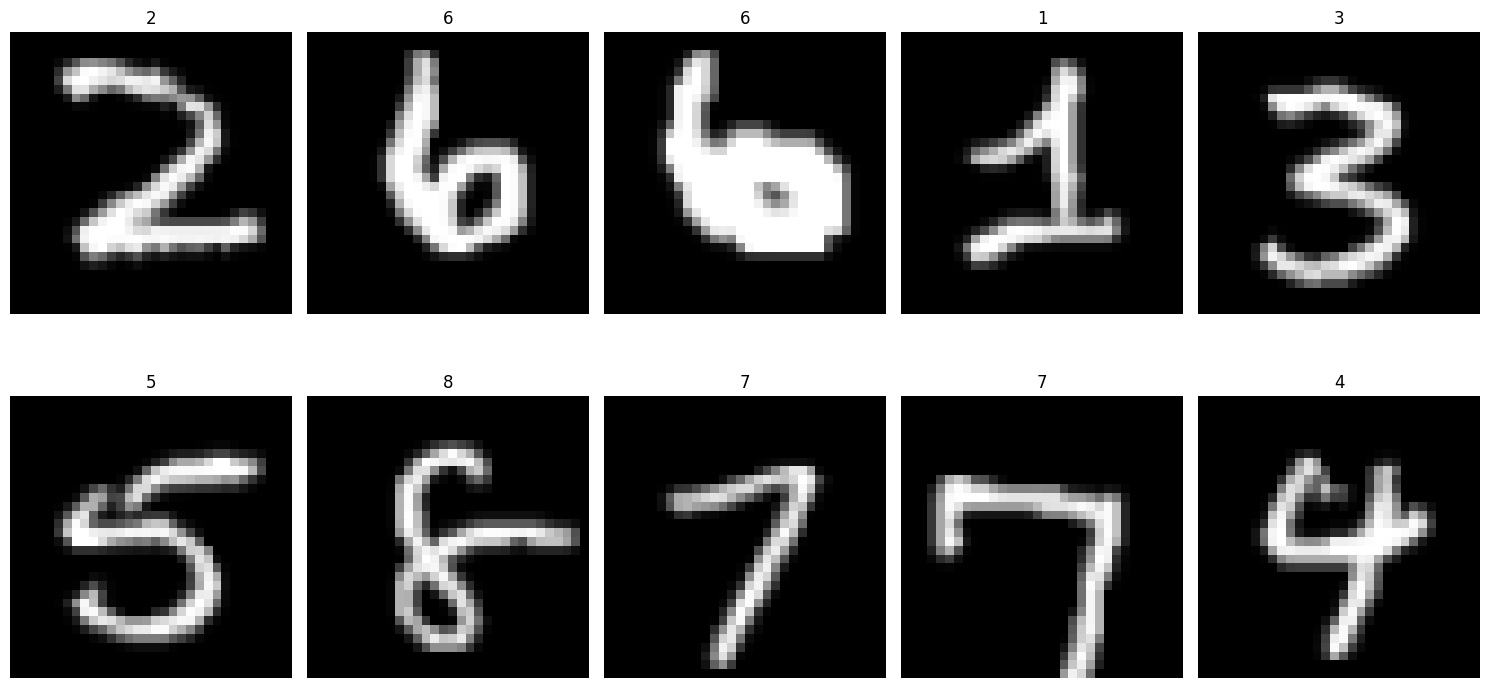

In [9]:
# Get a batch of images and labels
batch = dls.one_batch()

# Number of images to display
num_images = 10

# Create a figure with a grid of subplots (2 rows and 4 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Plot each image in the grid
for i in range(num_images):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    img = batch[0][i].cpu().squeeze().numpy()
    label = batch[1][i].item()
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

## Gradient Descent

In [7]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
ADAMW = partial(OptimWrapper, opt=torch.optim.AdamW)
optims2 = [NAG, RMSProp, ADAM, ADAMW]
utilsTFG.set_seed()

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for model, m in zip(models,mod):
        learners[opt][model] = Learner(dls=dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][model].to(device)
        learners[opt][model].model.to(device)
        utilsTFG.set_params_to_model(init_weights[model], learners[opt][model].model)


In [11]:
#To check if the models have the same initial parameters
for model in models:
  if utilsTFG.compare_models(learners['NAG'][model], learners['RMSProp'][model]) and utilsTFG.compare_models(learners['NAG'][model], learners['ADAM'][model]) and utilsTFG.compare_models(learners['ADAM'][model], learners['RMSProp'][model]):
    print(f"Mismos parámetros con el modelo {model}.")
  else:
    print("Distintos parámetros.")

Mismos parámetros con el modelo LeNet5.
Mismos parámetros con el modelo ResNet15.
Mismos parámetros con el modelo ResNet57.


### Nesterov

Better model found at epoch 0 with valid_loss value: 2.391087293624878.
Better model found at epoch 1 with valid_loss value: 2.010666847229004.
Better model found at epoch 2 with valid_loss value: 1.1377696990966797.
Better model found at epoch 3 with valid_loss value: 0.7587669491767883.
Better model found at epoch 4 with valid_loss value: 0.6042680144309998.
Better model found at epoch 5 with valid_loss value: 0.5170013904571533.
Better model found at epoch 6 with valid_loss value: 0.46256372332572937.
Better model found at epoch 7 with valid_loss value: 0.42482128739356995.
Better model found at epoch 8 with valid_loss value: 0.3884574770927429.
Better model found at epoch 9 with valid_loss value: 0.3649758994579315.
Better model found at epoch 10 with valid_loss value: 0.3439173698425293.
Better model found at epoch 11 with valid_loss value: 0.32844406366348267.
Better model found at epoch 12 with valid_loss value: 0.3152746260166168.
Better model found at epoch 13 with valid_loss 

Better model found at epoch 0 with valid_loss value: 2.5182957649230957.
Better model found at epoch 4 with valid_loss value: 1.6867756843566895.
Better model found at epoch 5 with valid_loss value: 0.7295191287994385.
Better model found at epoch 6 with valid_loss value: 0.4282901883125305.
Better model found at epoch 7 with valid_loss value: 0.33413586020469666.
Better model found at epoch 8 with valid_loss value: 0.296244740486145.
Better model found at epoch 9 with valid_loss value: 0.2695370614528656.
Better model found at epoch 11 with valid_loss value: 0.24523140490055084.
Better model found at epoch 12 with valid_loss value: 0.23709113895893097.
Better model found at epoch 13 with valid_loss value: 0.23433761298656464.
Better model found at epoch 14 with valid_loss value: 0.22513851523399353.
Better model found at epoch 15 with valid_loss value: 0.222079798579216.
Better model found at epoch 16 with valid_loss value: 0.2197762429714203.
Better model found at epoch 17 with valid_

Better model found at epoch 0 with valid_loss value: 2.6849136352539062.
Better model found at epoch 2 with valid_loss value: 2.596088171005249.
Better model found at epoch 3 with valid_loss value: 2.0577127933502197.
Better model found at epoch 4 with valid_loss value: 1.609714150428772.
Better model found at epoch 5 with valid_loss value: 1.206396460533142.
Better model found at epoch 6 with valid_loss value: 0.9161240458488464.
Better model found at epoch 7 with valid_loss value: 0.7614211440086365.
Better model found at epoch 8 with valid_loss value: 0.6389043927192688.
Better model found at epoch 9 with valid_loss value: 0.5690029859542847.
Better model found at epoch 10 with valid_loss value: 0.5120351314544678.
Better model found at epoch 11 with valid_loss value: 0.47436603903770447.
Better model found at epoch 12 with valid_loss value: 0.44981661438941956.
Better model found at epoch 13 with valid_loss value: 0.43078723549842834.
Better model found at epoch 14 with valid_loss 

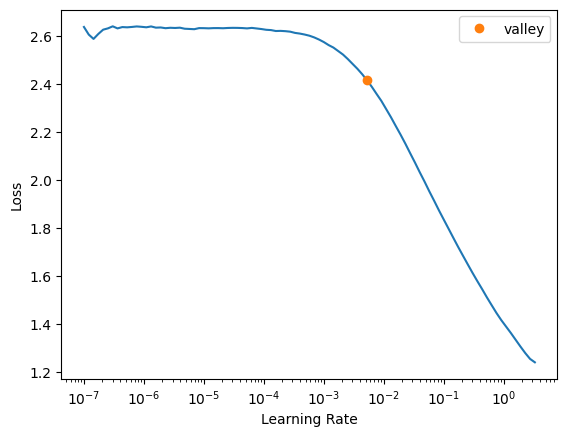

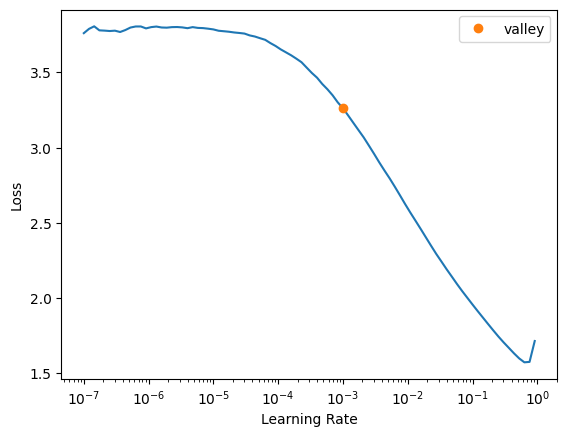

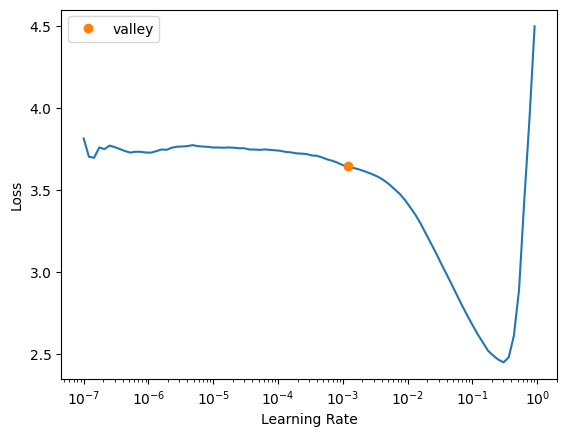

In [12]:
#Run the training and measure the time for each layer
for model, learner in learners['NAG'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][model] = end-start



<Figure size 1200x600 with 0 Axes>

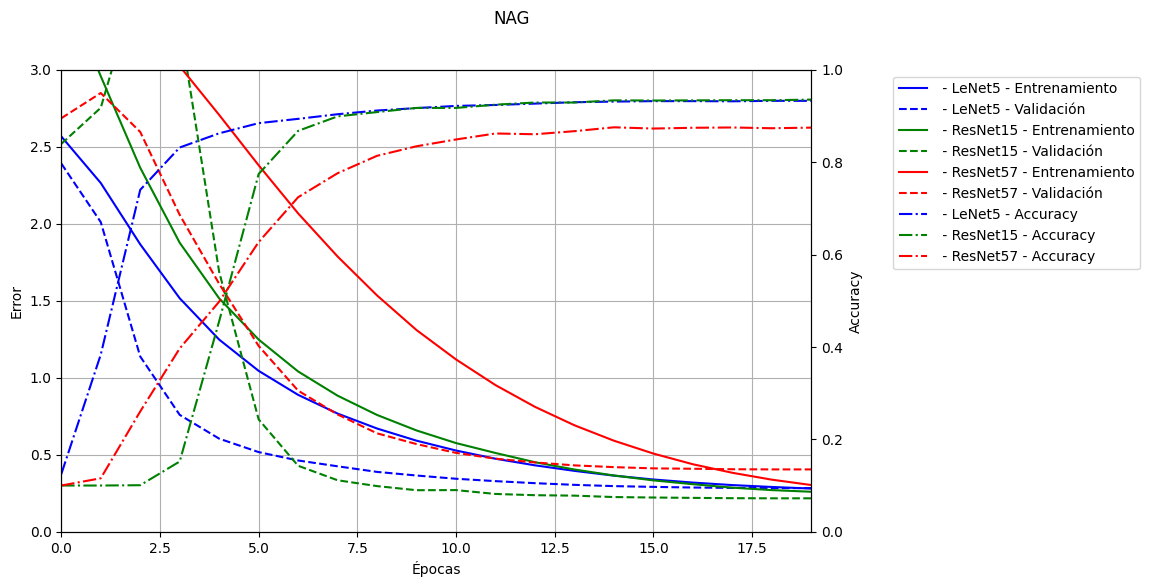

In [13]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), lim=3, title='NAG', names=models, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 1.4736520051956177.
Better model found at epoch 1 with valid_loss value: 0.31546977162361145.
Better model found at epoch 2 with valid_loss value: 0.23285764455795288.
Better model found at epoch 3 with valid_loss value: 0.16643288731575012.
Better model found at epoch 4 with valid_loss value: 0.11058194935321808.
Better model found at epoch 6 with valid_loss value: 0.09427366405725479.
Better model found at epoch 7 with valid_loss value: 0.08899090439081192.
Better model found at epoch 11 with valid_loss value: 0.0841355174779892.
Better model found at epoch 13 with valid_loss value: 0.08407407999038696.


Better model found at epoch 0 with valid_loss value: 2.595109224319458.
Better model found at epoch 4 with valid_loss value: 2.571398973464966.
Better model found at epoch 5 with valid_loss value: 0.5882652997970581.
Better model found at epoch 6 with valid_loss value: 0.25035560131073.
Better model found at epoch 7 with valid_loss value: 0.15980201959609985.
Better model found at epoch 8 with valid_loss value: 0.1493246704339981.
Better model found at epoch 9 with valid_loss value: 0.14616194367408752.
Better model found at epoch 10 with valid_loss value: 0.14209333062171936.
Better model found at epoch 11 with valid_loss value: 0.14063313603401184.
Better model found at epoch 12 with valid_loss value: 0.1400650292634964.
Better model found at epoch 13 with valid_loss value: 0.13916414976119995.
Better model found at epoch 14 with valid_loss value: 0.1376585215330124.


Better model found at epoch 0 with valid_loss value: 2.7432103157043457.
Better model found at epoch 4 with valid_loss value: 1.2821059226989746.
Better model found at epoch 5 with valid_loss value: 0.6054424047470093.
Better model found at epoch 6 with valid_loss value: 0.4332629442214966.
Better model found at epoch 7 with valid_loss value: 0.3891170620918274.


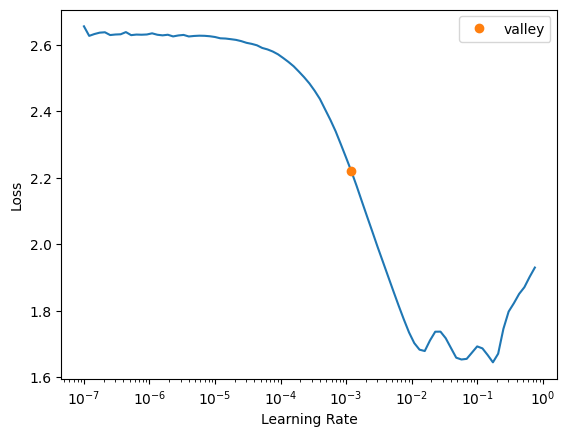

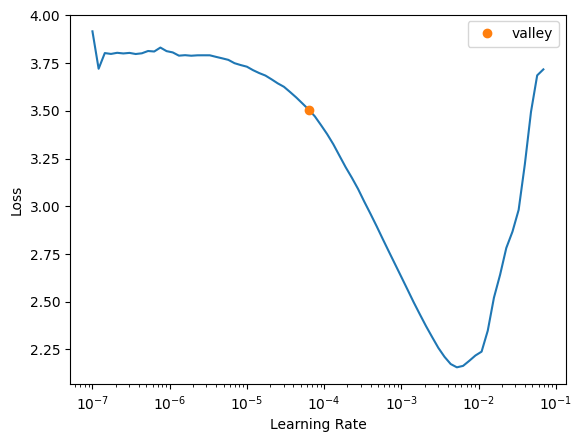

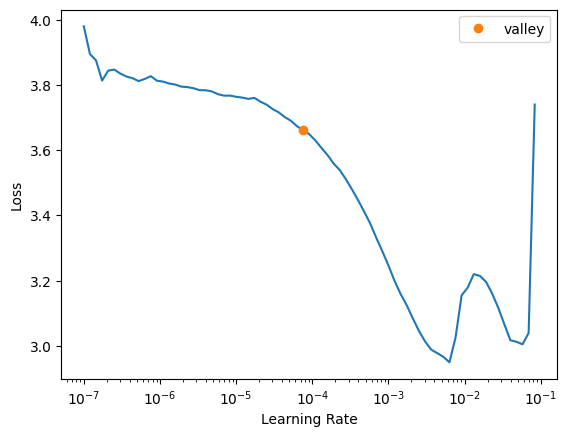

In [14]:
#Run the training and measure the time for each layer
for model, learner in learners['RMSProp'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][model] = end-start


<Figure size 1200x600 with 0 Axes>

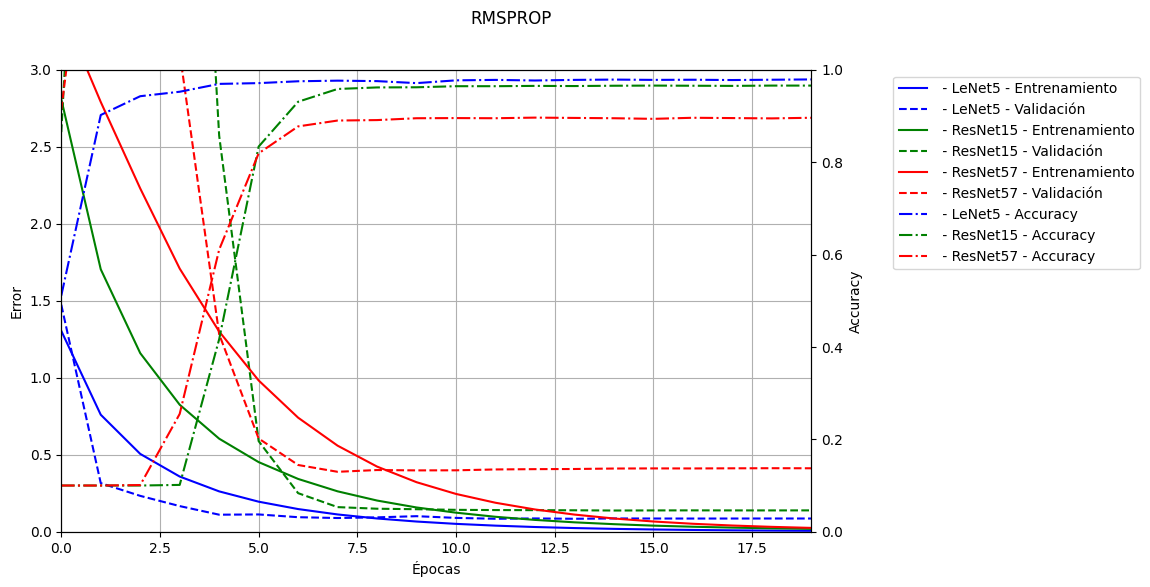

In [15]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), lim=3, title='RMSPROP', names=models, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 2.3568265438079834.
Better model found at epoch 1 with valid_loss value: 1.8244435787200928.
Better model found at epoch 2 with valid_loss value: 0.6956199407577515.
Better model found at epoch 3 with valid_loss value: 0.3654136657714844.
Better model found at epoch 4 with valid_loss value: 0.2701322138309479.
Better model found at epoch 5 with valid_loss value: 0.2278655618429184.
Better model found at epoch 6 with valid_loss value: 0.20202100276947021.
Better model found at epoch 7 with valid_loss value: 0.17697660624980927.
Better model found at epoch 8 with valid_loss value: 0.157917782664299.
Better model found at epoch 9 with valid_loss value: 0.14680324494838715.
Better model found at epoch 10 with valid_loss value: 0.13743291795253754.
Better model found at epoch 11 with valid_loss value: 0.13113032281398773.
Better model found at epoch 12 with valid_loss value: 0.12628847360610962.
Better model found at epoch 13 with valid_l

Better model found at epoch 0 with valid_loss value: 2.5057196617126465.
Better model found at epoch 4 with valid_loss value: 2.2972545623779297.
Better model found at epoch 5 with valid_loss value: 0.6301611065864563.
Better model found at epoch 6 with valid_loss value: 0.2740153670310974.
Better model found at epoch 7 with valid_loss value: 0.19531695544719696.
Better model found at epoch 8 with valid_loss value: 0.177353635430336.
Better model found at epoch 9 with valid_loss value: 0.16963297128677368.
Better model found at epoch 10 with valid_loss value: 0.16766192018985748.
Better model found at epoch 11 with valid_loss value: 0.16288423538208008.
Better model found at epoch 12 with valid_loss value: 0.16212336719036102.
Better model found at epoch 13 with valid_loss value: 0.16169804334640503.
Better model found at epoch 14 with valid_loss value: 0.15976175665855408.
Better model found at epoch 15 with valid_loss value: 0.15926894545555115.
Better model found at epoch 17 with va

Better model found at epoch 0 with valid_loss value: 2.6686813831329346.
Better model found at epoch 4 with valid_loss value: 1.8654124736785889.
Better model found at epoch 5 with valid_loss value: 0.8444286584854126.
Better model found at epoch 6 with valid_loss value: 0.48813721537590027.
Better model found at epoch 7 with valid_loss value: 0.42173904180526733.
Better model found at epoch 8 with valid_loss value: 0.4074207842350006.
Better model found at epoch 9 with valid_loss value: 0.3894621729850769.


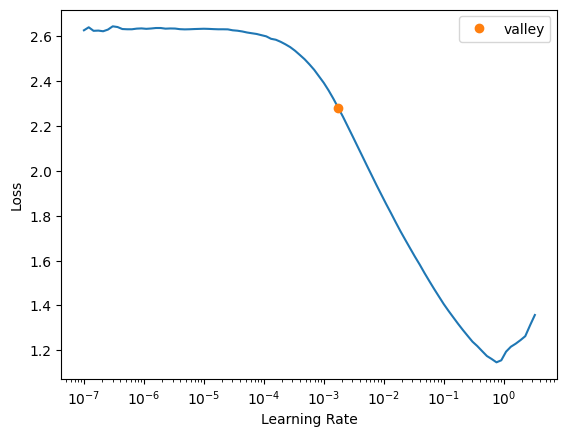

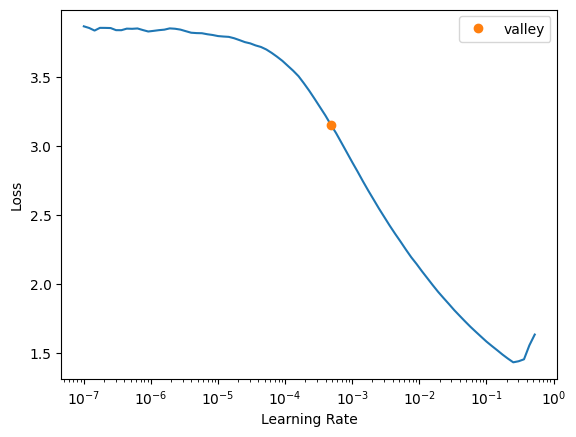

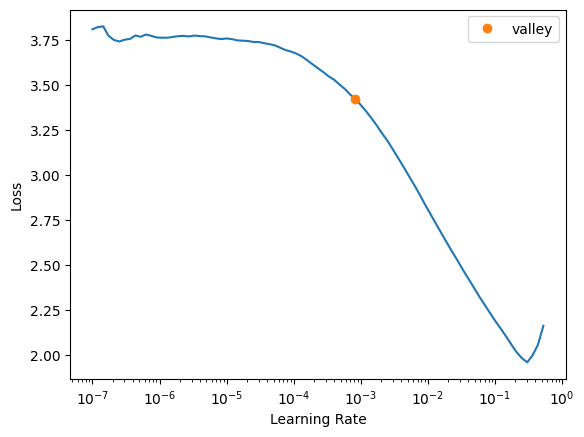

In [16]:
#Run the training and measure the time for each layer
for model, learner in learners['ADAM'].items():
  utilsTFG.set_seed()
  try:
    lr=learner.lr_find()
  except:
    lr=0.01
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][model] = end-start


<Figure size 1200x600 with 0 Axes>

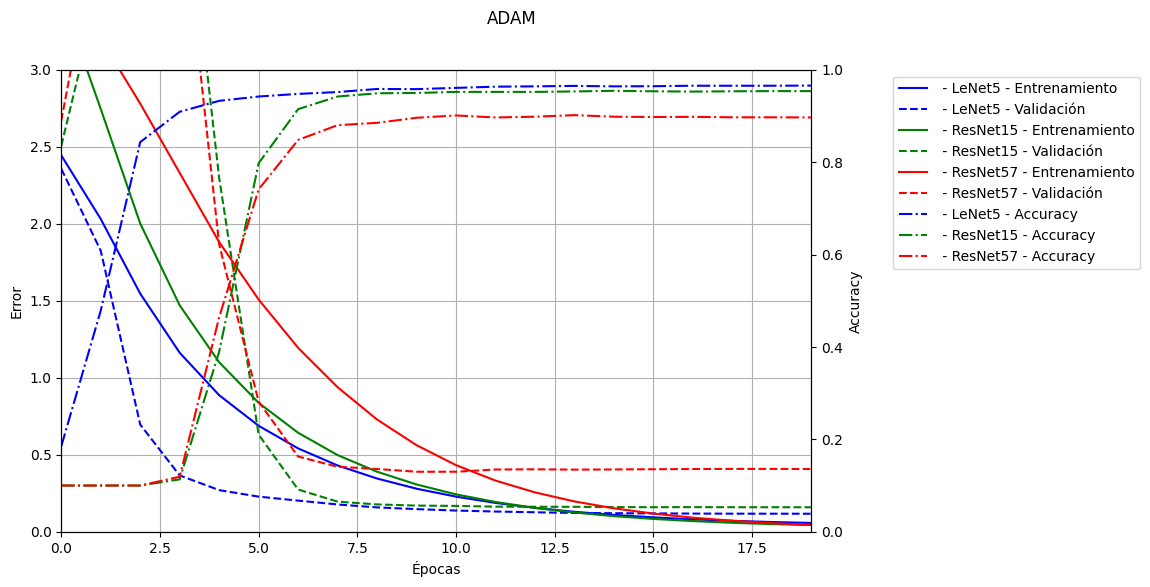

In [17]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='ADAM', lim=3, names=models, metric=metric)

### AdamW

Better model found at epoch 0 with valid_loss value: 2.3440165519714355.
Better model found at epoch 1 with valid_loss value: 1.7150999307632446.
Better model found at epoch 2 with valid_loss value: 0.6081089377403259.
Better model found at epoch 3 with valid_loss value: 0.3278486430644989.
Better model found at epoch 4 with valid_loss value: 0.25543493032455444.
Better model found at epoch 5 with valid_loss value: 0.22134283185005188.
Better model found at epoch 6 with valid_loss value: 0.17724916338920593.
Better model found at epoch 7 with valid_loss value: 0.16462691128253937.
Better model found at epoch 8 with valid_loss value: 0.1413877308368683.
Better model found at epoch 9 with valid_loss value: 0.1320343017578125.
Better model found at epoch 10 with valid_loss value: 0.12704959511756897.
Better model found at epoch 11 with valid_loss value: 0.11933249235153198.
Better model found at epoch 12 with valid_loss value: 0.11659514158964157.
Better model found at epoch 13 with valid

Better model found at epoch 0 with valid_loss value: 2.5014188289642334.
Better model found at epoch 4 with valid_loss value: 1.9373477697372437.
Better model found at epoch 5 with valid_loss value: 0.5260159373283386.
Better model found at epoch 6 with valid_loss value: 0.22036828100681305.
Better model found at epoch 7 with valid_loss value: 0.17537906765937805.
Better model found at epoch 8 with valid_loss value: 0.1630113273859024.
Better model found at epoch 9 with valid_loss value: 0.15591458976268768.
Better model found at epoch 10 with valid_loss value: 0.15354135632514954.
Better model found at epoch 12 with valid_loss value: 0.1516886055469513.
Better model found at epoch 13 with valid_loss value: 0.14947441220283508.


Better model found at epoch 0 with valid_loss value: 2.6652305126190186.
Better model found at epoch 4 with valid_loss value: 2.41963791847229.
Better model found at epoch 5 with valid_loss value: 0.938814103603363.
Better model found at epoch 6 with valid_loss value: 0.5654860734939575.
Better model found at epoch 7 with valid_loss value: 0.3983059823513031.
Better model found at epoch 8 with valid_loss value: 0.38011449575424194.
Better model found at epoch 9 with valid_loss value: 0.36980152130126953.
Better model found at epoch 10 with valid_loss value: 0.35946932435035706.
Better model found at epoch 11 with valid_loss value: 0.3581221103668213.


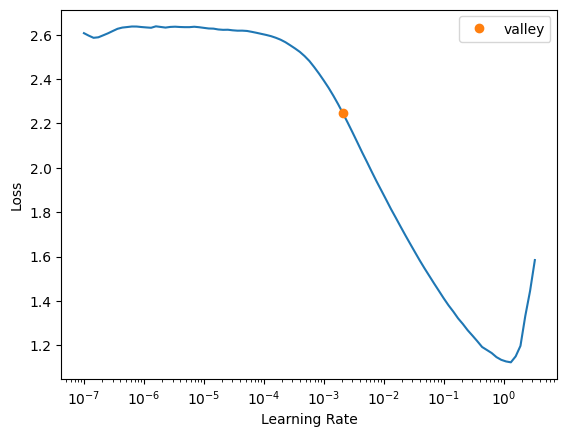

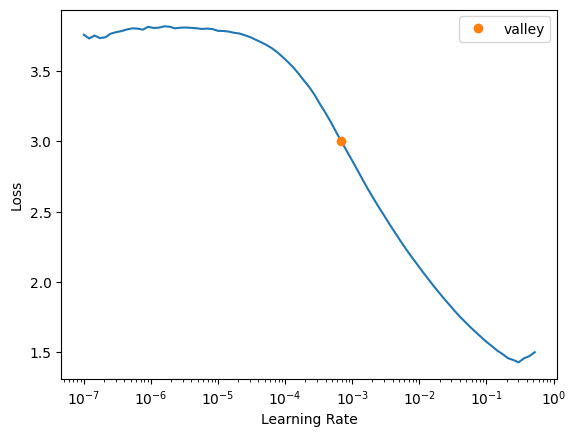

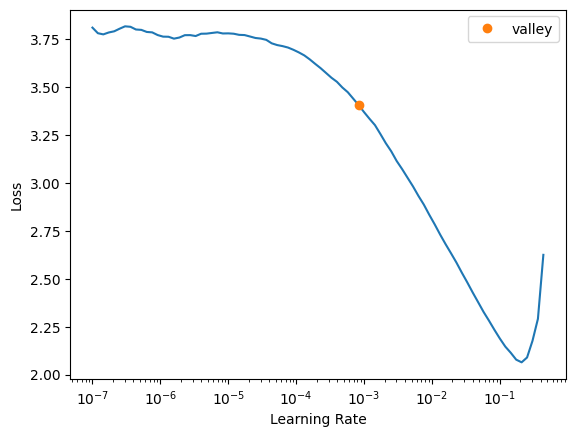

In [18]:
#Run the training and measure the time for each layer
for model, learner in learners['ADAMW'].items():
  utilsTFG.set_seed()
  try:
    lr=learner.lr_find()
  except:
    lr=0.01
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAMW'][model] = end-start

<Figure size 1200x600 with 0 Axes>

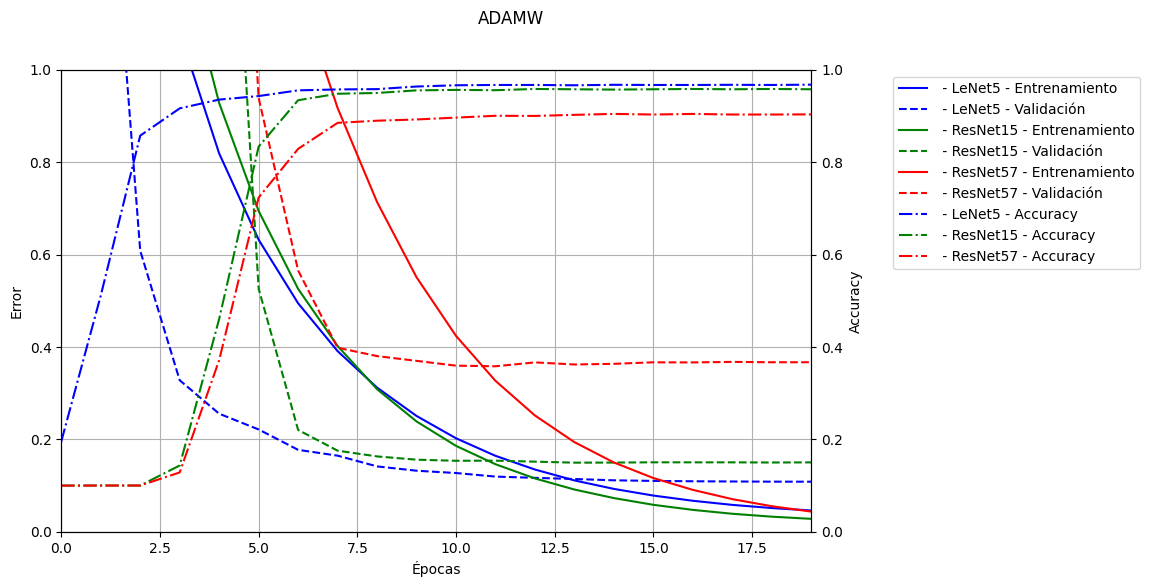

In [19]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAMW'].values(), title='ADAMW', names=models, metric=metric)

### Save or Load models

In [20]:
#Save learner with their losses and metrics
for optim in optims:
  for model in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][model], 'recorder_values': learners[optim][model].recorder.values}, f)


In [21]:
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_gd, f)

In [8]:
#Load learner with their losses and metrics
for optim in optims:
  for model in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][model], learners[optim][model].recorder.values = data['learner'], data['recorder_values']
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'

with open(file_path, 'rb') as f:
    time_gd = pickle.load(f)

### Comparative per models

<Figure size 1200x600 with 0 Axes>

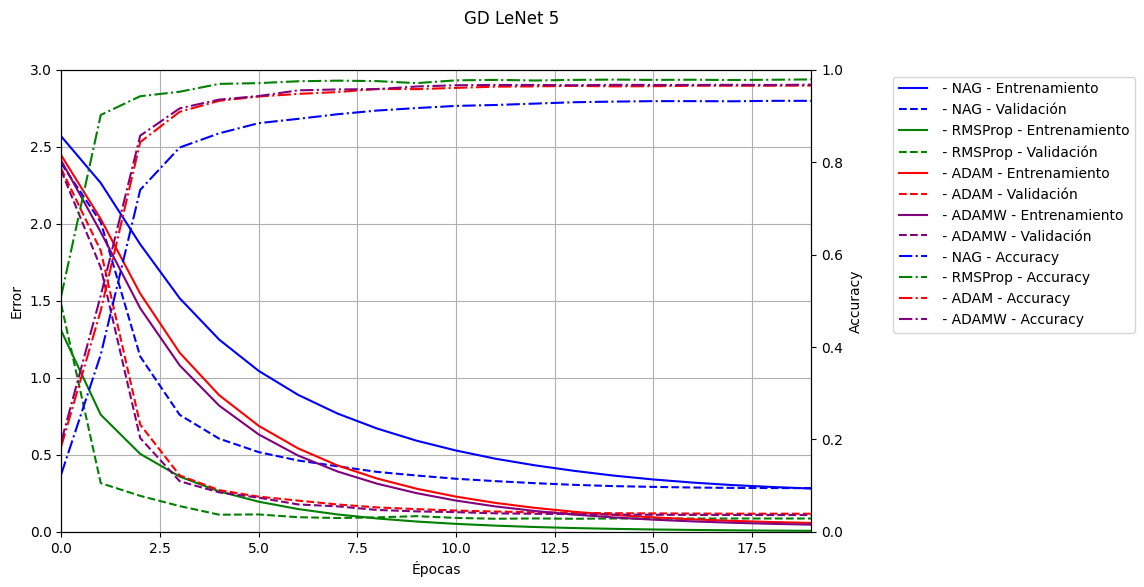

<Figure size 1200x600 with 0 Axes>

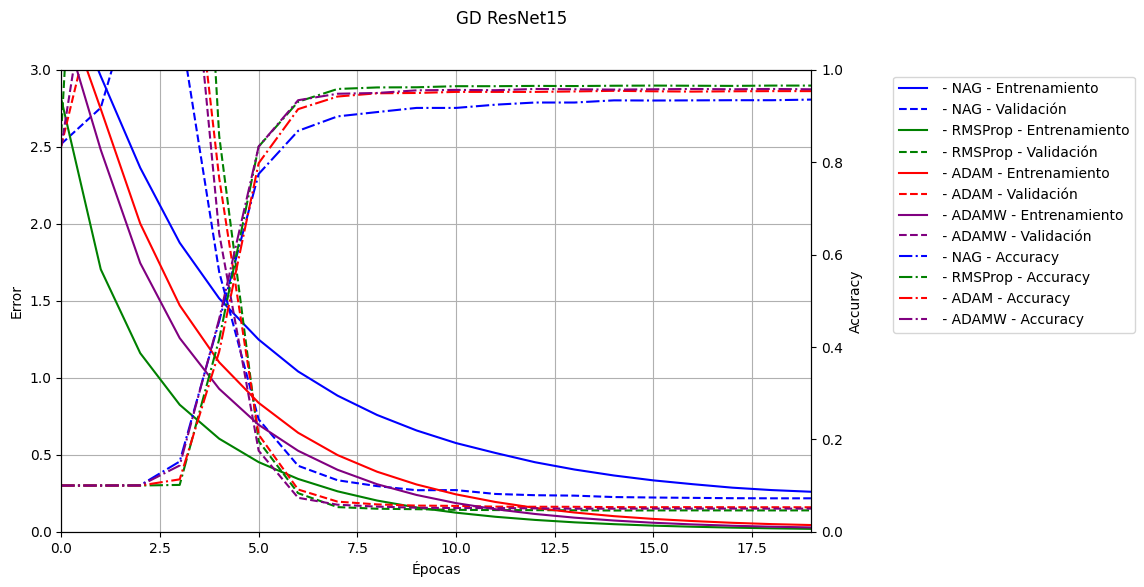

<Figure size 1200x600 with 0 Axes>

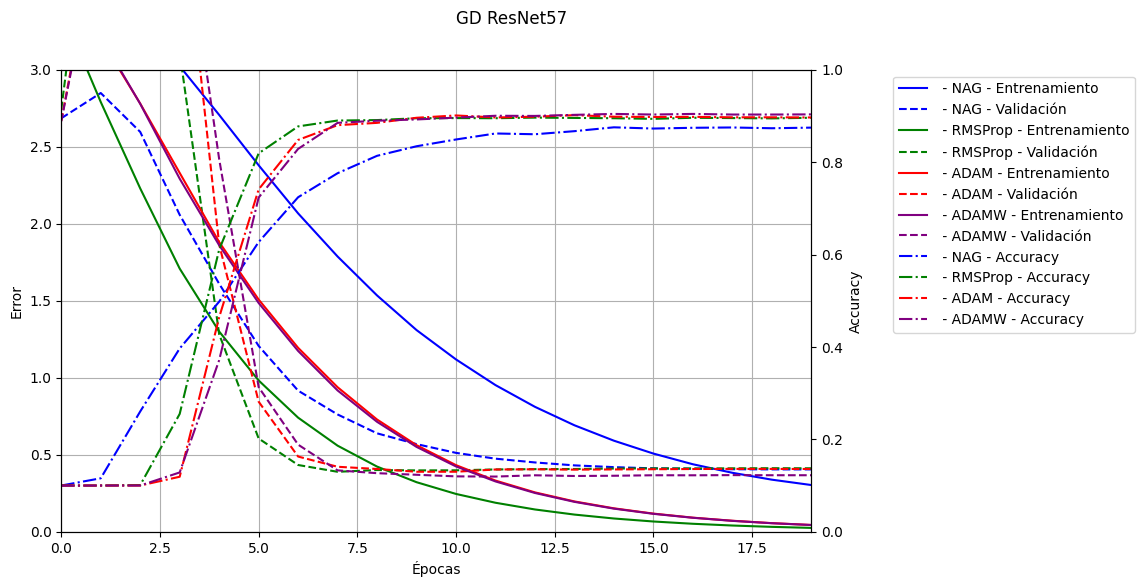

In [9]:
#Compare the three optimizers for each layer

learners_lenet =[learners['NAG']['LeNet5'], learners['RMSProp']['LeNet5'], learners['ADAM']['LeNet5'], learners['ADAMW']['LeNet5']]
learners_resnet = [learners['NAG']['ResNet15'], learners['RMSProp']['ResNet15'], learners['ADAM']['ResNet15'], learners['ADAMW']['ResNet15']]
learners_resnet57 = [learners['NAG']['ResNet57'], learners['RMSProp']['ResNet57'], learners['ADAM']['ResNet57'], learners['ADAMW']['ResNet57']]

names=['NAG', 'RMSProp', 'ADAM', 'ADAMW']
utilsTFG.plot_learners_training(learners_lenet, lim= 3, title='GD LeNet 5', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet, lim= 3, title='GD ResNet15', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet57, lim= 3, title='GD ResNet57', names=names, metric=metric)

### Generalization

In [23]:
models =['LeNet5', 'ResNet15', 'ResNet57'] #Sometimes it overrides the array
#Run the model in the test set
for optim in optims:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][model].model.eval()
    learners[optim][model].eval()
    preds, targs = learners[optim][model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][model].model, test_dl, mode = 'test')
    #loss = CrossEntropyLossFlat()(preds, targs)


    print(f"Optimizer: {optim}, Model: {model}, Loss: {loss}, Accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: NAG, Model: LeNet5, Loss: 0.2591063976287842, Accuracy: 0.9433999999999999


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: NAG, Model: ResNet15, Loss: 0.20211899280548096, Accuracy: 0.9411999999999999


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: NAG, Model: ResNet57, Loss: 0.38063111901283264, Accuracy: 0.8827999999999999


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: RMSProp, Model: LeNet5, Loss: 0.07092653959989548, Accuracy: 0.9806000000000001


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: RMSProp, Model: ResNet15, Loss: 0.10755210369825363, Accuracy: 0.9673999999999999


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: RMSProp, Model: ResNet57, Loss: 0.37021514773368835, Accuracy: 0.8943999999999999


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAM, Model: LeNet5, Loss: 0.09777706861495972, Accuracy: 0.976


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAM, Model: ResNet15, Loss: 0.13856765627861023, Accuracy: 0.9569999999999999


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAM, Model: ResNet57, Loss: 0.36112111806869507, Accuracy: 0.8934


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAMW, Model: LeNet5, Loss: 0.09071137756109238, Accuracy: 0.9768000000000001


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAMW, Model: ResNet15, Loss: 0.1215837225317955, Accuracy: 0.9624


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAMW, Model: ResNet57, Loss: 0.38333970308303833, Accuracy: 0.901


## Metaheuristics

In [10]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}
utilsTFG.set_seed()

#Initialise the population to have the same values for all the MH
for model,m in zip(models,mod):
  population[model] = []
  fitness[model] = []
  optim = RMSProp
  mh_learners[model] = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(),  cbs=[SaveModelCallback()], opt_func=optim)
  mh_learners[model].to(device)
  mh_learners[model].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[model].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    #population[model].append(utilsTFG.get_params_from_model(model_copy))

    #fitness[model].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


### Genetic Algorithms

In [22]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

In [25]:

file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(population, f)

file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(fitness, f)

In [10]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'rb') as f:
    population = pickle.load(f)

file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'rb') as f:
    fitness = pickle.load(f)

In [11]:
models=['LeNet5', 'ResNet15', 'ResNet57']
for alg in algs:
    results[alg] = {}
    for model in models:        
        file_path = f'/notebooks/saved_models/{alg}_dict_{model}_{dataset}.pkl'
        with open(file_path, 'rb') as f:
            results[alg][model] = pickle.load(f)
        file_path = f'/notebooks/saved_models/{alg}_time_{model}_{dataset}.pkl'
        with open(file_path, 'rb') as f:
            time_mh[alg][model] = pickle.load(f)

In [12]:
time_full_mh = {}
for alg in ['SHADE', 'SHADE-ILS']:
    time_full_mh[alg]= time_mh[alg]

In [12]:
#Runing SHADE algorithm
for model in ['LeNet5', 'ResNet15']:
  print(f"Iniciando SHADE con {model}")
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][model] = utilsTFG.SHADE_ej(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), pop_size,max_evals, len(population[model][0]), dls,  model=mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(results['SHADE'][model], f)
  file_path = f'/notebooks/saved_models/SHADE_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(time_mh['SHADE'][model], f)


Iniciando SHADE con LeNet5
Iniciando SHADE con ResNet15


In [12]:
for model in ['ResNet57']:
  print(f"Iniciando SHADE con {model}")
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][model] = utilsTFG.SHADE_ej(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), pop_size,max_evals, len(population[model][0]), dls,  model=mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(results['SHADE'][model], f)
  file_path = f'/notebooks/saved_models/SHADE_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(time_mh['SHADE'][model], f)

Iniciando SHADE con ResNet57


In [15]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for model in models:
  fitness_valid['SHADE'][model] = []
  start = time.perf_counter()
  for ind in results['SHADE'][model][5]:
    fitness_valid['SHADE'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))
  end = time.perf_counter()
  time_full_mh['SHADE'][model]+= end-start

In [16]:
#compare train and valid and select the best generalizing model.
for model in models:
  print(f"Training error of SHADE for {model} model: {results['SHADE'][model][6]}")
  print(f"Validation error of SHADE for {model} model: {fitness_valid['SHADE'][model]}")
  dif = np.array(fitness_valid['SHADE'][model]) - np.array(results['SHADE'][model][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][model])
  best['SHADE'][model] = results['SHADE'][model][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for LeNet5 model: [2.5301520824432373, 2.424363851547241, 2.424363851547241, 2.424363851547241, 2.379028081893921, 2.3202641010284424, 2.317486524581909, 2.317486524581909, 2.317486524581909, 2.317486524581909, 2.317486524581909, 2.317486524581909, 2.317486524581909, 2.317486524581909, 2.317486524581909, 2.317486524581909, 2.3063676357269287, 2.3063676357269287, 2.2890734672546387, 2.256934642791748, 2.217466115951538, 2.217466115951538, 2.191401481628418, 2.191401481628418, 2.1856632232666016, 2.183983564376831, 2.1491568088531494, 2.1223394870758057, 2.121248722076416, 2.1063239574432373, 2.0981922149658203, 2.0921196937561035, 2.0919137001037598, 2.0845720767974854, 2.07822847366333, 2.0714759826660156, 2.0261666774749756, 2.013043165206909, 1.9860378503799438, 1.9860378503799438, 1.962255597114563, 1.9382479190826416, 1.9326117038726807, 1.9168425798416138, 1.9109455347061157, 1.8875226974487305, 1.8875226974487305, 1.8859822750091553, 1.848095178604126, 1.8

In [17]:
#Modify the shade lenght to adjust the others algorithms. I have selected the best before so we cant lose it.
for model in models:
    # Convert the tuple to a list
    shade_list = list(results['SHADE'][model])
    
    # Modify the list
    shade_list[6] = [np.mean(shade_list[6][i:i+5]) for i in range(0, len(shade_list[6]), 5)]
    
    # Convert the list back to a tuple and assign it back to results['SHADE'][layer]
    results['SHADE'][model] = tuple(shade_list)
    
    
    
    fitness_valid['SHADE'][model] = [np.mean(fitness_valid['SHADE'][model][i:i+5]) for i in range(0, len(fitness_valid['SHADE'][model]), 5)]

### SHADE-ILS

In [12]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for model in ['LeNet5', 'ResNet15']:
  utilsTFG.set_seed()
  print(f'Iniciado {model}')
  start = time.perf_counter()
  results['SHADE-ILS'][model] = utilsTFG.SHADE_ILS(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(results['SHADE-ILS'][model], f)

  file_path = f'/notebooks/saved_models/SHADE-ILS_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(time_mh['SHADE-ILS'][model], f)


Iniciado LeNet5
deque([1, 1, 0.9940133066850624], maxlen=3)
233
deque([1, 0.9940133066850624, 0.8336828733976339], maxlen=3)
445
deque([0.9940133066850624, 0.8336828733976339, -0.09672775062661275], maxlen=3)
653
deque([0.8336828733976339, -0.09672775062661275, 0.6525815514395684], maxlen=3)
865
deque([-0.09672775062661275, 0.6525815514395684, 0.2241526299151825], maxlen=3)
1078
deque([0.6525815514395684, 0.2241526299151825, 0.05970968294850613], maxlen=3)
1293
deque([0.2241526299151825, 0.05970968294850613, 0.4562466698973684], maxlen=3)
1506
deque([0.05970968294850613, 0.4562466698973684, 0.23933638005095256], maxlen=3)
1723
deque([0.4562466698973684, 0.23933638005095256, 0.06398179961428382], maxlen=3)
1933
deque([0.23933638005095256, 0.06398179961428382, 0.06893542532595867], maxlen=3)
2146
deque([0.06398179961428382, 0.06893542532595867, -0.030943059462158112], maxlen=3)
2356
deque([0.06893542532595867, -0.030943059462158112, 0.07509329672743442], maxlen=3)
2569
deque([-0.03094305

In [13]:
for model in ['ResNet57']:
  utilsTFG.set_seed()
  print(f'Iniciado {model}')
  start = time.perf_counter()
  results['SHADE-ILS'][model] = utilsTFG.SHADE_ILS(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(results['SHADE-ILS'][model], f)

  file_path = f'/notebooks/saved_models/SHADE-ILS_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(time_mh['SHADE-ILS'][model], f)


Iniciado ResNet57
deque([1, 1, 0.29645353745435465], maxlen=3)
237
deque([1, 0.29645353745435465, 0.013934449051495537], maxlen=3)
452
deque([0.29645353745435465, 0.013934449051495537, 0.010291982983060215], maxlen=3)
666
deque([0.013934449051495537, 0.010291982983060215, 0.03568223556947086], maxlen=3)
Reiniciado
892
deque([1, 1, 0.5814279529422182], maxlen=3)
1103
deque([1, 0.5814279529422182, 0.4699568958037757], maxlen=3)
1315
deque([0.5814279529422182, 0.4699568958037757, 0.8484319752050735], maxlen=3)
1527
deque([0.4699568958037757, 0.8484319752050735, 0.9002040830019638], maxlen=3)
1739
deque([0.8484319752050735, 0.9002040830019638, 0.8122654063954093], maxlen=3)
1952
deque([0.9002040830019638, 0.8122654063954093, 0.6147148300898556], maxlen=3)
2165
deque([0.8122654063954093, 0.6147148300898556, 0.4232035927753135], maxlen=3)
2380
deque([0.6147148300898556, 0.4232035927753135, 0.055468807602136294], maxlen=3)
2590
deque([0.4232035927753135, 0.055468807602136294, -0.0003715464241

In [18]:
fitness_valid['SHADE-ILS'] = {}
for model in models:
  fitness_valid['SHADE-ILS'][model] = []
  start = time.perf_counter()
  for ind in results['SHADE-ILS'][model][3]:
    fitness_valid['SHADE-ILS'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))
  end = time.perf_counter()
  time_full_mh['SHADE-ILS'][model] += end-start

In [19]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS for {model} model: {results['SHADE-ILS'][model][2]}")
  print(f"Validation error of SHADE-ILS for {model} model: {fitness_valid['SHADE-ILS'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS'][model]) - np.array(results['SHADE-ILS'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][model])
  best['SHADE-ILS'][model] = results['SHADE-ILS'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for LeNet5 model: [2.5301520824432373, 0.015147244557738304, 0.0025192461907863617, 0.0025192461907863617, 0.0009598918841220438, 0.0007447295938618481, 0.0007002620259299874, 0.000380769808543846, 0.00028963774093426764, 0.0002711061970330775, 0.00025241737603209913, 0.00025241737603209913, 0.00024068656784947962, 0.00024068656784947962, 0.00023676746059209108, 0.00023676746059209108, 0.00023676746059209108, 0.00023676746059209108, 0.00023676746059209108, 0.00023676746059209108, 0.00023676746059209108]
Validation error of SHADE-ILS for LeNet5 model: [2.2991740703582764, 4.776839256286621, 5.734560966491699, 5.734560966491699, 5.5836334228515625, 5.740856170654297, 5.744828701019287, 6.048525810241699, 6.196500778198242, 6.355696678161621, 6.389324188232422, 6.389324188232422, 6.273184776306152, 6.273184776306152, 6.423534393310547, 6.423534393310547, 6.423534393310547, 6.423534393310547, 6.423534393310547, 6.423534393310547, 6.423534393310547]
Difference: [

### SHADE-GD

Iniciado LeNet5
deque([1, 1, 0.0829546899062751], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.4927539825439453.
deque([1, 0.0829546899062751, 0.6356616333533466], maxlen=3)
deque([0.0829546899062751, 0.6356616333533466, 0.41539316473860466], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.40368470549583435.
deque([0.6356616333533466, 0.41539316473860466, 0.11308509881935626], maxlen=3)
deque([0.41539316473860466, 0.11308509881935626, 0.1329645820189505], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.362303227186203.
deque([0.11308509881935626, 0.1329645820189505, 0.04493957763156863], maxlen=3)
deque([0.1329645820189505, 0.04493957763156863, 0.0772367800368426], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.3085816204547882.
deque([0.04493957763156863, 0.0772367800368426, 0.07411448525344093], maxlen=3)
deque([0.0772367800368426, 0.07411448525344093, 0.12100129271045275], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.2858714163303375.
deque([0.07411448525344093, 0.12100129271045275, 0.039440017720985876], maxlen=3)
deque([0.12100129271045275, 0.039440017720985876, 0.1270936934543556], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.23776090145111084.
deque([0.039440017720985876, 0.1270936934543556, 0.04975628545932307], maxlen=3)
deque([0.1270936934543556, 0.04975628545932307, 0.2020240872725197], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.19921129941940308.
deque([0.04975628545932307, 0.2020240872725197, 0.054350153229935014], maxlen=3)
deque([0.2020240872725197, 0.054350153229935014, 0.18879320291660517], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.17749810218811035.
deque([0.054350153229935014, 0.18879320291660517, 0.004324148259137746], maxlen=3)
deque([0.18879320291660517, 0.004324148259137746, 0.17024295809450177], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.15577508509159088.
deque([0.004324148259137746, 0.17024295809450177, 0.002367899244588112], maxlen=3)
deque([0.17024295809450177, 0.002367899244588112, 0.15370468132813195], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.1493237316608429.
deque([0.002367899244588112, 0.15370468132813195, 0.003231713097987039], maxlen=3)
deque([0.15370468132813195, 0.003231713097987039, 0.13646211784073936], maxlen=3)
Iniciado ResNet15
deque([1, 1, 0.21327565993602737], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6430505514144897.
deque([1, 0.21327565993602737, 0.707011170078551], maxlen=3)
deque([0.21327565993602737, 0.707011170078551, 0.15790395832366483], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.2664838135242462.
deque([0.707011170078551, 0.15790395832366483, 0.40290539424601435], maxlen=3)
deque([0.15790395832366483, 0.40290539424601435, 0.318751944646409], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.17866772413253784.
deque([0.40290539424601435, 0.318751944646409, 0.2169058571815518], maxlen=3)
deque([0.318751944646409, 0.2169058571815518, 0.26682058462818786], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.14828667044639587.
deque([0.2169058571815518, 0.26682058462818786, 0.16128915727766954], maxlen=3)
deque([0.26682058462818786, 0.16128915727766954, 0.37720263391761577], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.1395217627286911.
deque([0.16128915727766954, 0.37720263391761577, 0.13579743788905205], maxlen=3)
deque([0.37720263391761577, 0.13579743788905205, 0.29150257998085394], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.12396204471588135.
deque([0.13579743788905205, 0.29150257998085394, 0.044204970502657655], maxlen=3)
deque([0.29150257998085394, 0.044204970502657655, 0.28474472448828936], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.11721142381429672.
deque([0.044204970502657655, 0.28474472448828936, 0.02602423948234572], maxlen=3)
deque([0.28474472448828936, 0.02602423948234572, 0.34381374984767976], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.11423096805810928.
deque([0.02602423948234572, 0.34381374984767976, 0.0], maxlen=3)
deque([0.34381374984767976, 0.0, 0.036545124022728324], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.11506198346614838.
deque([0.0, 0.036545124022728324, 0.007063801891492099], maxlen=3)
Reiniciado
deque([1, 1, 0.506951412077586], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.587353527545929.
deque([1, 0.506951412077586, 0.6093040830736985], maxlen=3)
deque([0.506951412077586, 0.6093040830736985, 0.27041787928086053], maxlen=3)


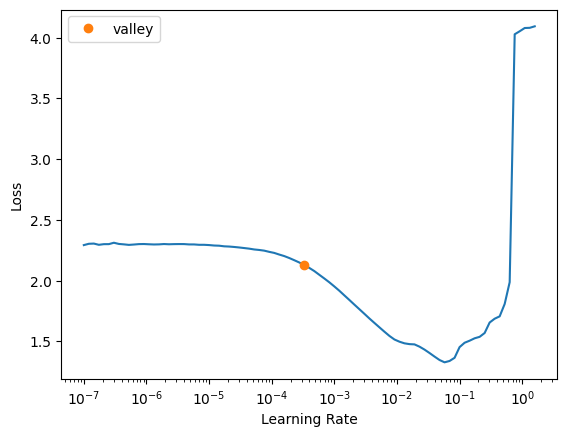

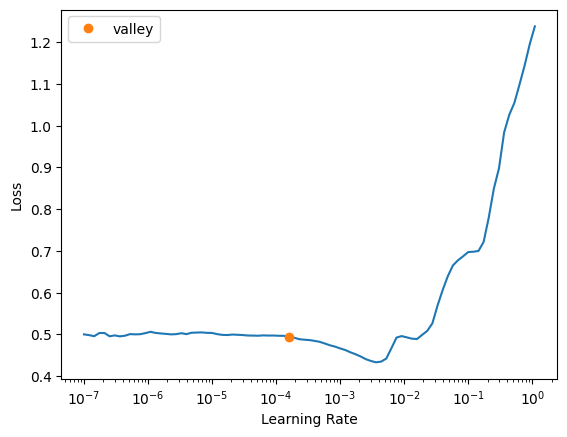

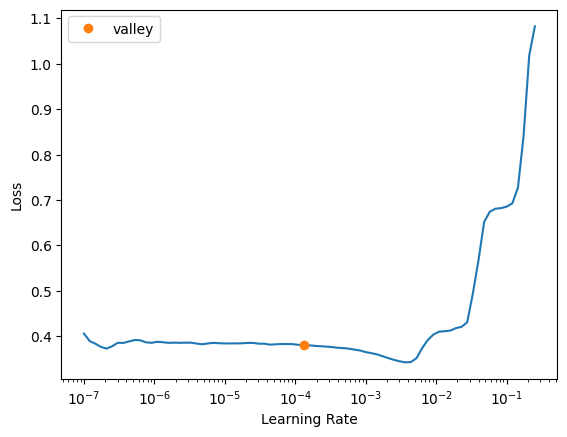

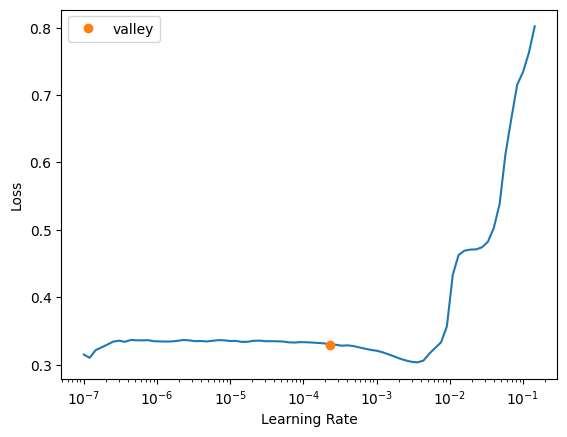

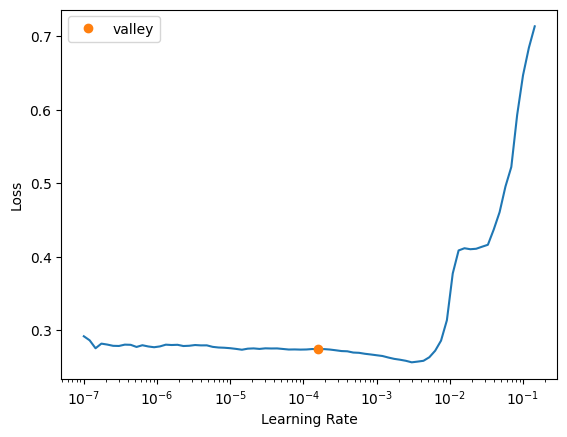

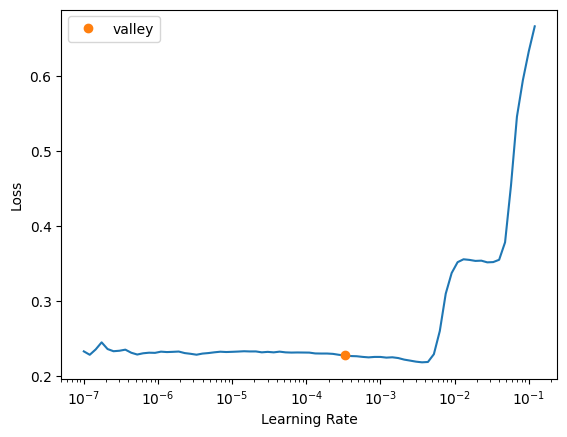

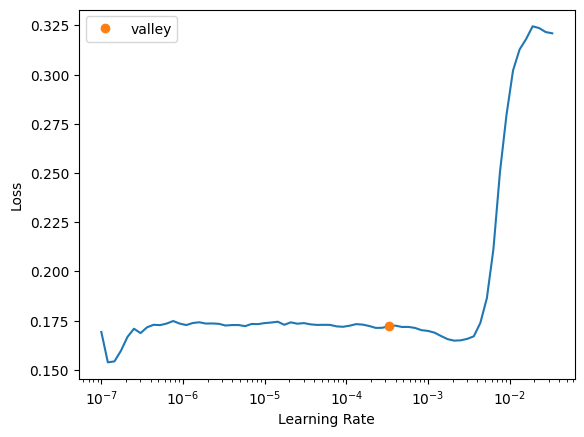

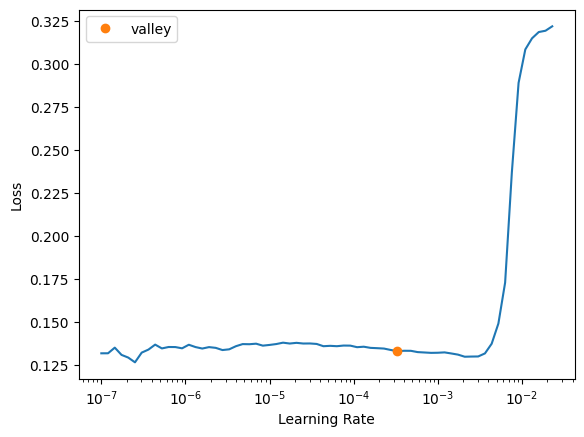

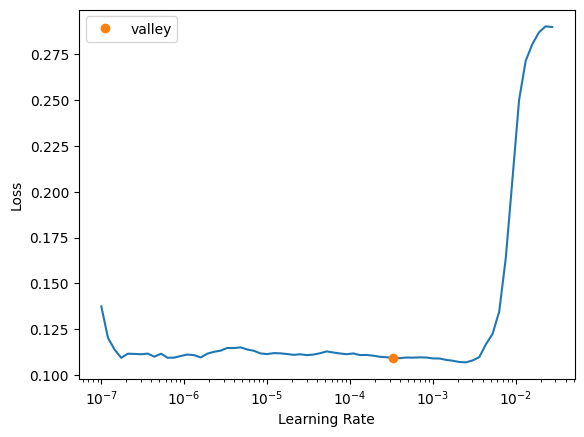

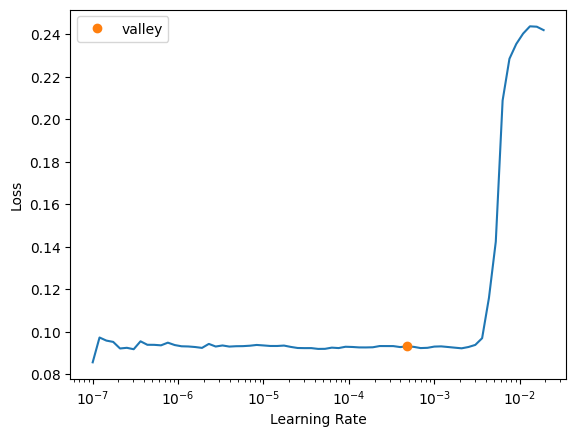

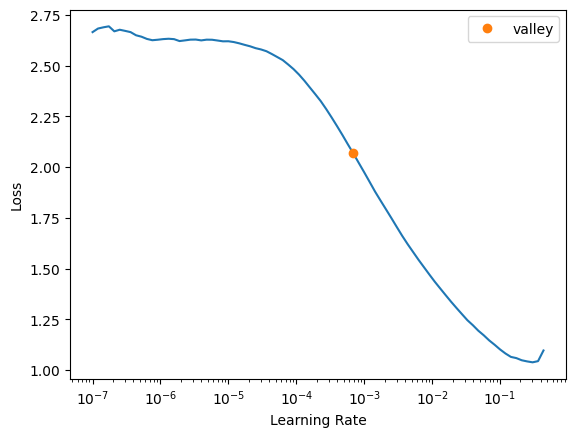

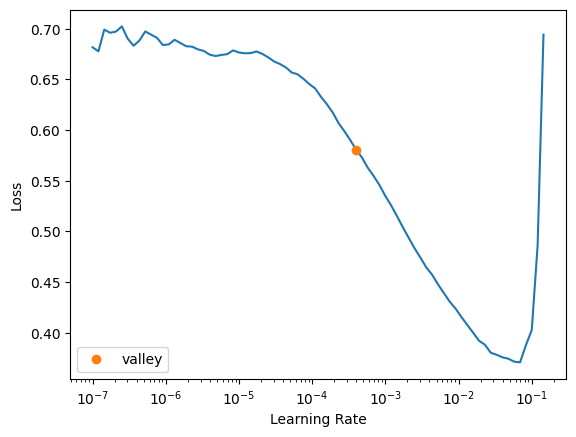

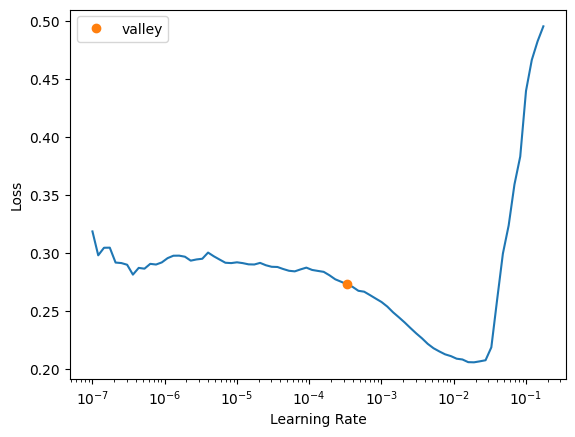

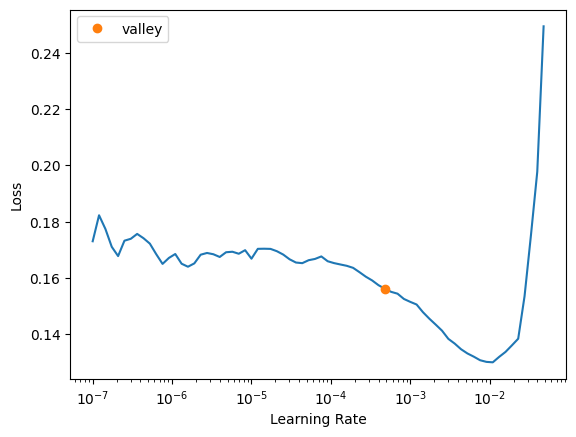

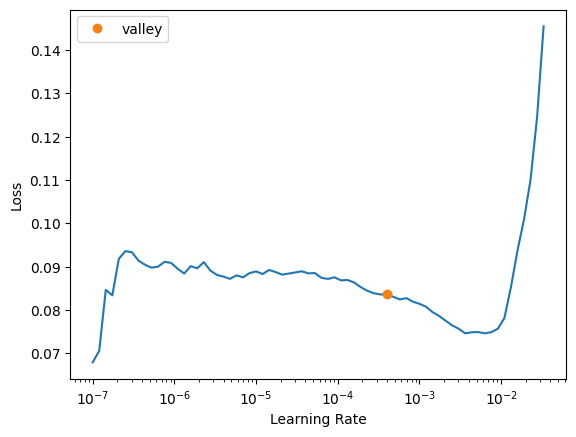

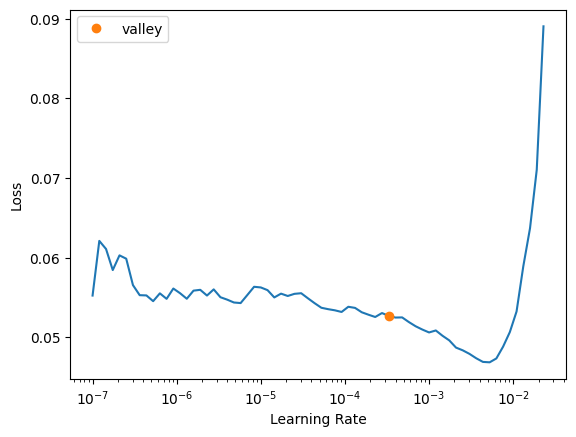

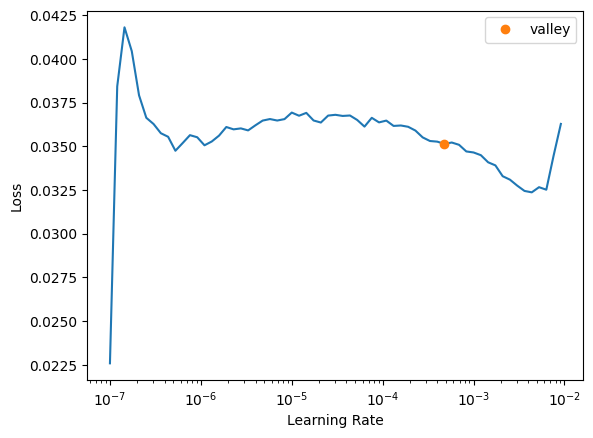

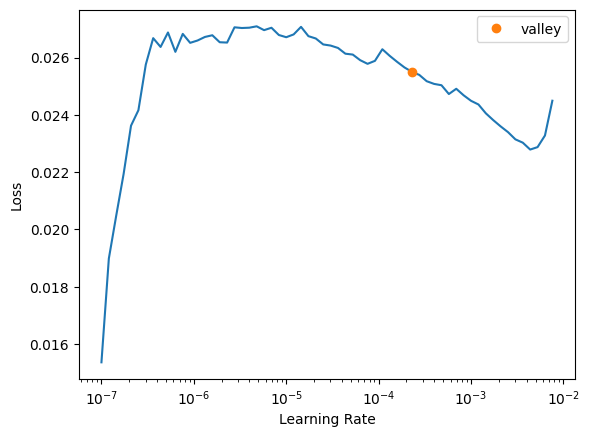

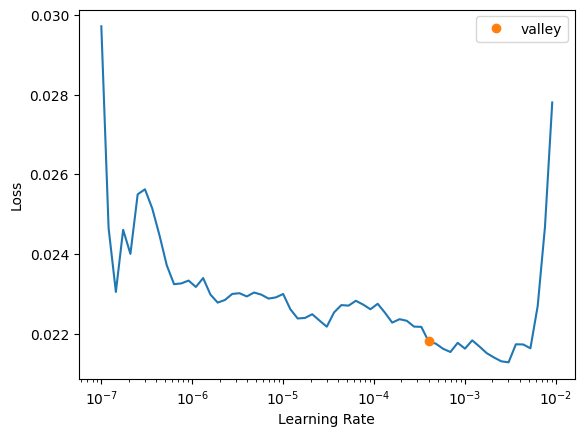

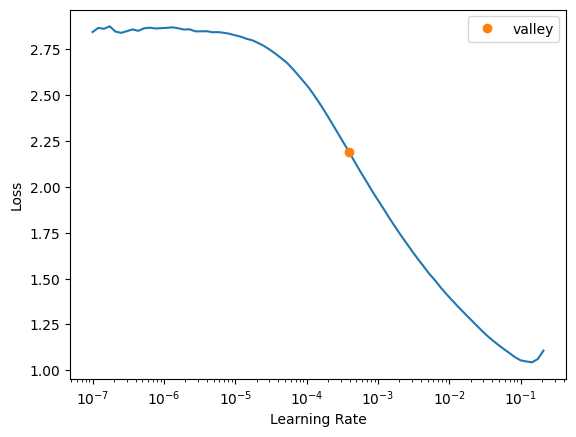

In [11]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for model in ['LeNet5', 'ResNet15']:
  utilsTFG.set_seed()
  print(f'Iniciado {model}') 
  start = time.perf_counter()
  results['SHADE-GD'][model] = utilsTFG.SHADE_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(results['SHADE-GD'][model], f)

  file_path = f'/notebooks/saved_models/SHADE-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(time_mh['SHADE-GD'][model], f)


Iniciado ResNet57
deque([1, 1, 0.24971825654358268], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.046186923980713.
deque([1, 0.24971825654358268, 0.446309076453769], maxlen=3)
deque([0.24971825654358268, 0.446309076453769, 0.2024194969632096], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7463151216506958.
deque([0.446309076453769, 0.2024194969632096, 0.22984166124891448], maxlen=3)
deque([0.2024194969632096, 0.22984166124891448, 0.18650952048386205], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6459800004959106.
deque([0.22984166124891448, 0.18650952048386205, 0.07082861709579497], maxlen=3)
deque([0.18650952048386205, 0.07082861709579497, 0.12415855346982722], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6029583215713501.
deque([0.07082861709579497, 0.12415855346982722, 0.045734761882139874], maxlen=3)
deque([0.12415855346982722, 0.045734761882139874, 0.1782531869805669], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5524151921272278.
deque([0.045734761882139874, 0.1782531869805669, 0.001154952845555796], maxlen=3)
deque([0.1782531869805669, 0.001154952845555796, 0.2517203679847454], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5241998434066772.
deque([0.001154952845555796, 0.2517203679847454, 0.00891832135368385], maxlen=3)
deque([0.2517203679847454, 0.00891832135368385, 0.1967980944491786], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5058868527412415.
deque([0.00891832135368385, 0.1967980944491786, 0.0], maxlen=3)
deque([0.1967980944491786, 0.0, 0.22150729974900538], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.4774932563304901.
deque([0.0, 0.22150729974900538, 0.02547723690409617], maxlen=3)
deque([0.22150729974900538, 0.02547723690409617, 0.2583215678390253], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.4584614634513855.
deque([0.02547723690409617, 0.2583215678390253, 0.005684026163656264], maxlen=3)
deque([0.2583215678390253, 0.005684026163656264, 0.22192046959322403], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.4529782831668854.
deque([0.005684026163656264, 0.22192046959322403, 0.010526855325433], maxlen=3)
deque([0.22192046959322403, 0.010526855325433, 0.17498964729399533], maxlen=3)


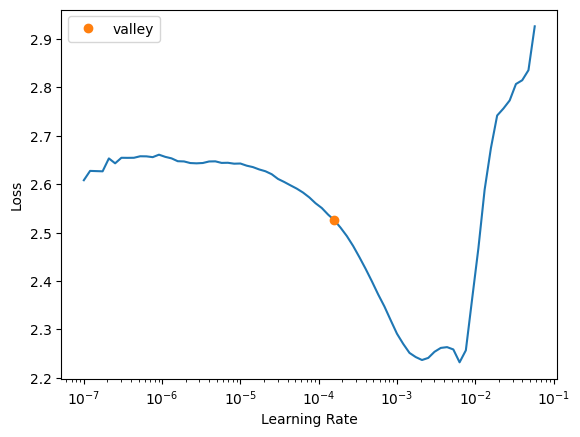

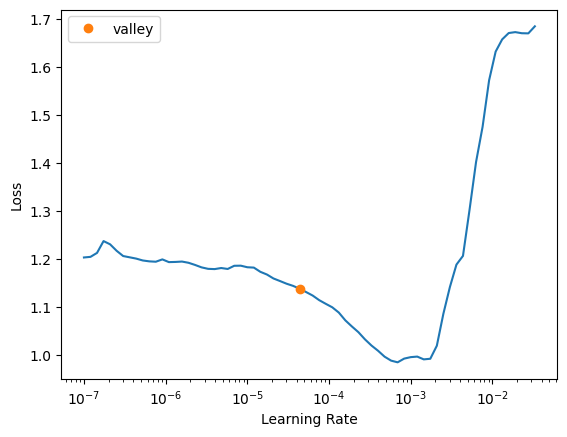

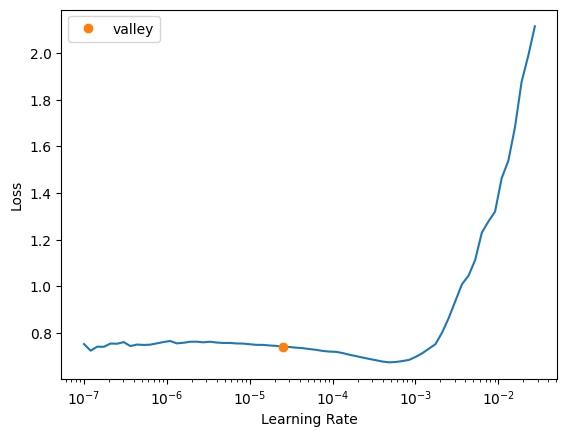

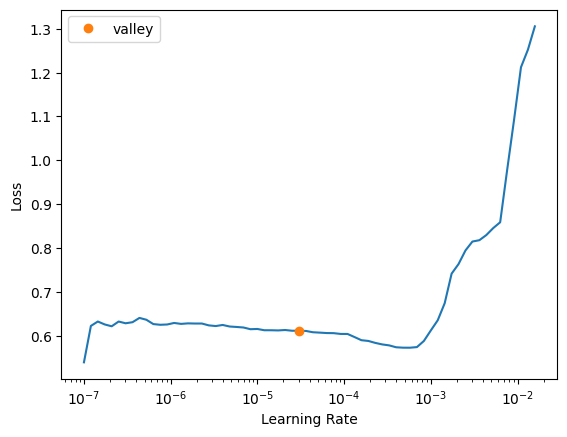

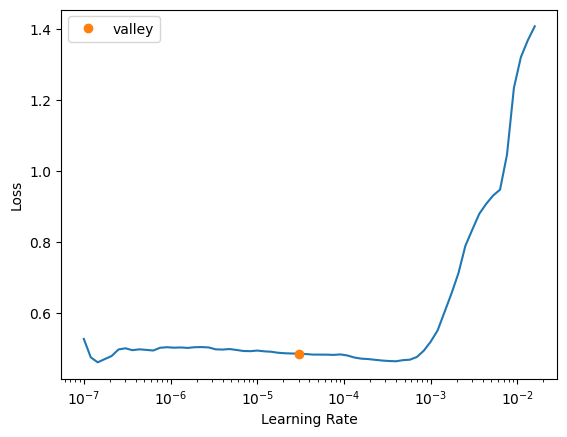

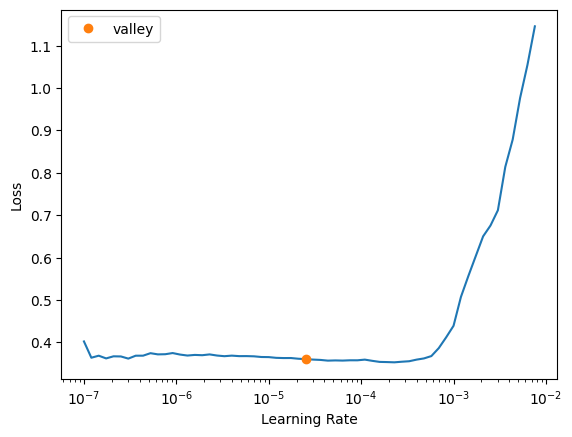

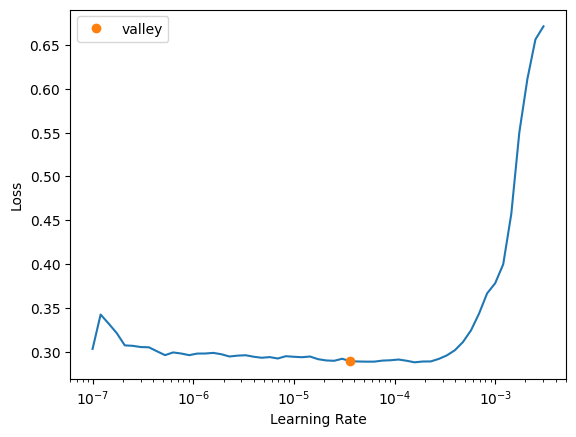

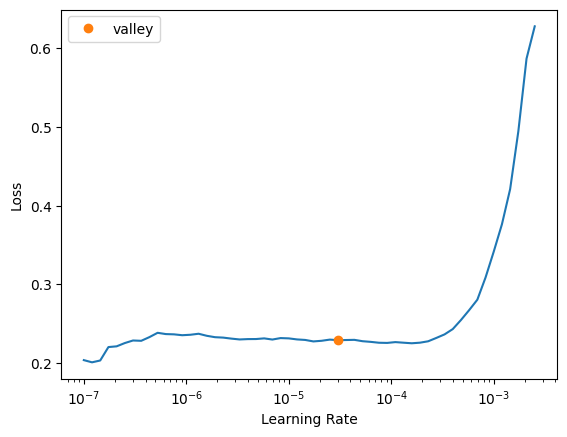

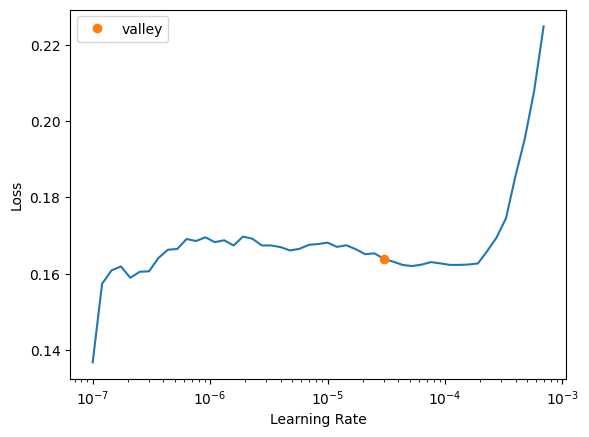

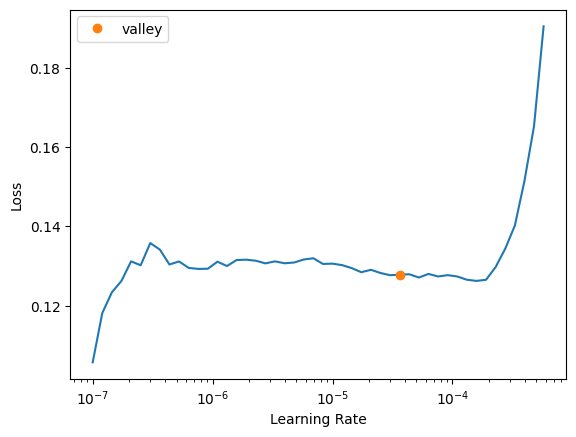

In [11]:
for model in ['ResNet57']:
  utilsTFG.set_seed()
  print(f'Iniciado {model}') 
  start = time.perf_counter()
  results['SHADE-GD'][model] = utilsTFG.SHADE_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(results['SHADE-GD'][model], f)

  file_path = f'/notebooks/saved_models/SHADE-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(time_mh['SHADE-GD'][model], f)

In [20]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for model in models:
  fitness_valid['SHADE-GD'][model] = []
  for ind in results['SHADE-GD'][model][3]:
    fitness_valid['SHADE-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [21]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-GD for {model} model: {results['SHADE-GD'][model][2]}")
  print(f"Validation error of SHADE-GD for {model} model: {fitness_valid['SHADE-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-GD'][model]) - np.array(results['SHADE-GD'][model][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][model])
  best['SHADE-GD'][model] = results['SHADE-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for LeNet5 model: [2.5301520824432373, 2.3202641010284424, 0.8453612327575684, 0.49420395493507385, 0.43831685185432434, 0.38003623485565186, 0.36295756697654724, 0.3349238932132721, 0.310101181268692, 0.27257853746414185, 0.2618280351161957, 0.22855134308338165, 0.21717947721481323, 0.1733039915561676, 0.16388489305973053, 0.13294453918933868, 0.13236966729164124, 0.10983466356992722, 0.1095745861530304, 0.09273245930671692, 0.09243277460336685, 0.0798192024230957]
Validation error of SHADE-GD for LeNet5 model: [2.2991740703582764, 2.2892537117004395, 2.0542051792144775, 2.0807433128356934, 2.0405707359313965, 2.0481908321380615, 2.029388427734375, 2.0345234870910645, 2.0080528259277344, 2.0007898807525635, 1.989683985710144, 1.985663652420044, 1.9723796844482422, 1.962937831878662, 1.9538220167160034, 1.9459586143493652, 1.9476083517074585, 1.939866542816162, 1.9266327619552612, 1.9368431568145752, 1.9354403018951416, 1.9326696395874023]
Difference: [-0.230

### SHADE-ILS-GD

deque([1, 1, 0.9938717865545563], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08935221284627914.
deque([1, 0.9938717865545563, 0.8541364365822632], maxlen=3)
deque([0.9938717865545563, 0.8541364365822632, 0.2184917965820842], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08095235377550125.
deque([0.8541364365822632, 0.2184917965820842, 0.6396013636519315], maxlen=3)
deque([0.2184917965820842, 0.6396013636519315, 0.03207080389323822], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08063492178916931.
deque([0.6396013636519315, 0.03207080389323822, 0.032066743203515546], maxlen=3)
deque([0.03207080389323822, 0.032066743203515546, 0.12145279768107914], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.07891907542943954.
deque([0.032066743203515546, 0.12145279768107914, -0.019441629595025812], maxlen=3)
deque([0.12145279768107914, -0.019441629595025812, 0.05432036249946912], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.07995357364416122.
deque([-0.019441629595025812, 0.05432036249946912, 0.06860971401612442], maxlen=3)
deque([0.05432036249946912, 0.06860971401612442, -0.010224549650741481], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08032763004302979.
deque([0.06860971401612442, -0.010224549650741481, 0.011954996324184978], maxlen=3)
deque([-0.010224549650741481, 0.011954996324184978, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 0.32267725467681885.
deque([1, 1, 0.9801456016249237], maxlen=3)
deque([1, 0.9801456016249237, 0.8416532624148917], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08206455409526825.
deque([0.9801456016249237, 0.8416532624148917, 0.7712891270514716], maxlen=3)
deque([0.8416532624148917, 0.7712891270514716, 0.16416840387140216], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08099833875894547.
deque([0.7712891270514716, 0.16416840387140216, 0.593917004137363], maxlen=3)
deque([0.16416840387140216, 0.593917004137363, 0.2227488609632276], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08760789781808853.
deque([0.593917004137363, 0.2227488609632276, 0.003411007737821643], maxlen=3)
deque([1, 1, 0.9972163508319664], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.15249839425086975.
deque([1, 0.9972163508319664, 0.5211769478668663], maxlen=3)
deque([0.9972163508319664, 0.5211769478668663, 0.58440322851074], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08679182827472687.
deque([0.5211769478668663, 0.58440322851074, 0.19565124368985304], maxlen=3)
deque([0.58440322851074, 0.19565124368985304, 0.07904614303862667], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08560065925121307.
deque([0.19565124368985304, 0.07904614303862667, 0.05418814817643523], maxlen=3)
deque([0.07904614303862667, 0.05418814817643523, -0.07400952638683427], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.08686527609825134.
deque([0.05418814817643523, -0.07400952638683427, 0.035952956501125295], maxlen=3)
deque([-0.07400952638683427, 0.035952956501125295, 0.049569276150949804], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.569032907485962.
deque([1, 1, 0.9836915017059961], maxlen=3)
deque([1, 0.9836915017059961, 0.8812143667853356], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.13655723631381989.
deque([0.9836915017059961, 0.8812143667853356, 0.7670750666299159], maxlen=3)
deque([0.8812143667853356, 0.7670750666299159, 0.1386327299946378], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.09970080852508545.
deque([0.7670750666299159, 0.1386327299946378, 0.44243805715452394], maxlen=3)
deque([0.1386327299946378, 0.44243805715452394, 0.1960656668498494], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.09772934019565582.
deque([0.44243805715452394, 0.1960656668498494, 0.1670317825814233], maxlen=3)
deque([0.1960656668498494, 0.1670317825814233, 0.04108138317139553], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.09859808534383774.
deque([0.1670317825814233, 0.04108138317139553, -0.025062601383416722], maxlen=3)
deque([0.04108138317139553, -0.025062601383416722, 0.12214450462076908], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.09728842973709106.
deque([-0.025062601383416722, 0.12214450462076908, 0.018508769822286598], maxlen=3)


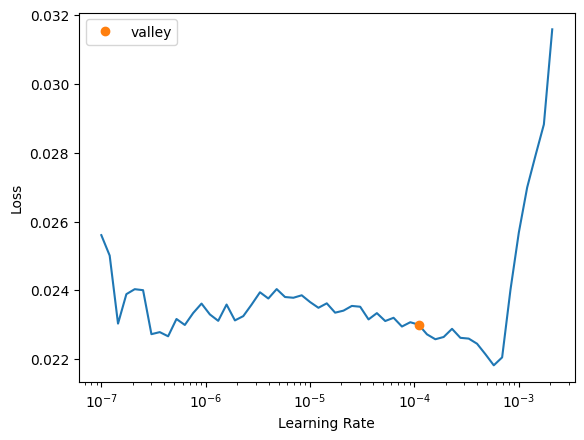

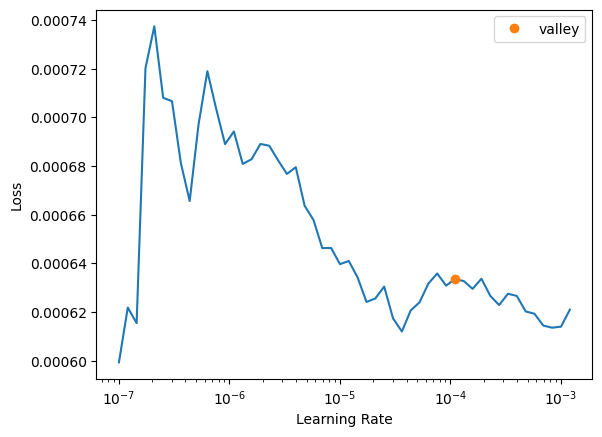

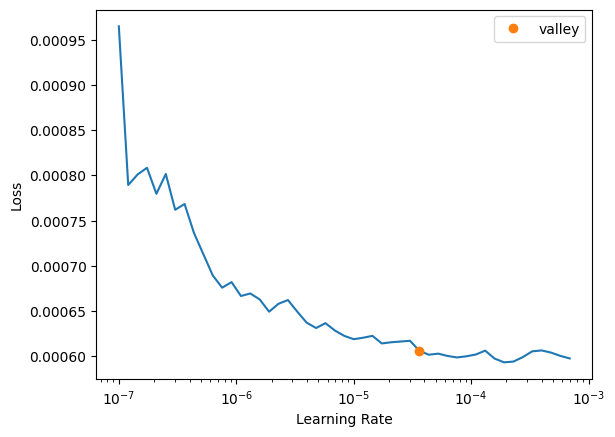

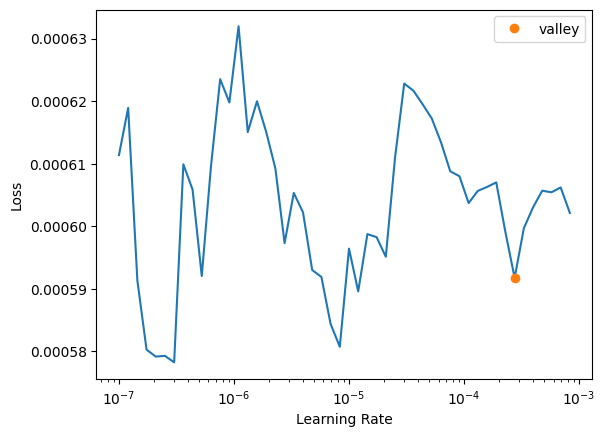

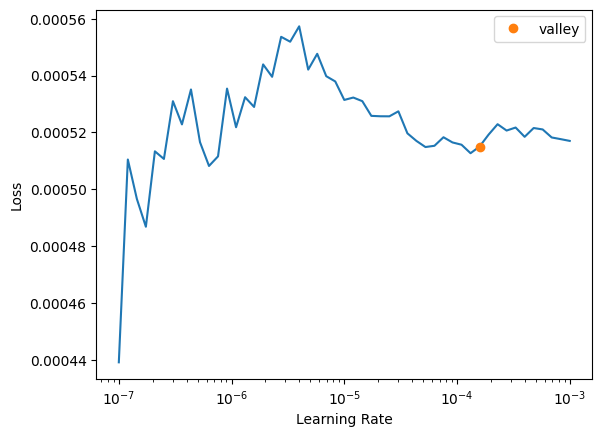

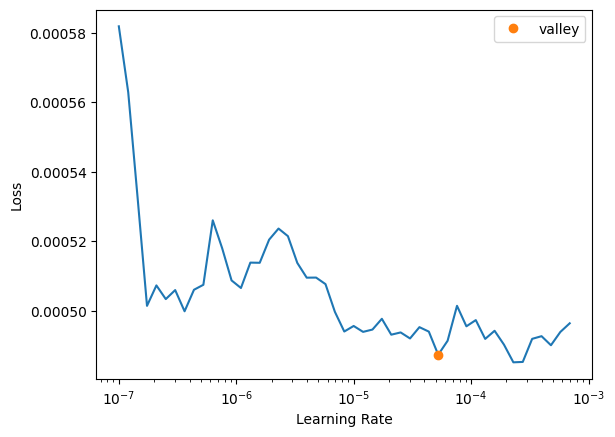

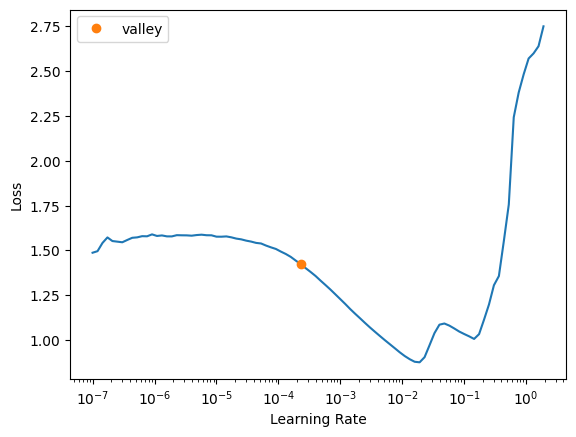

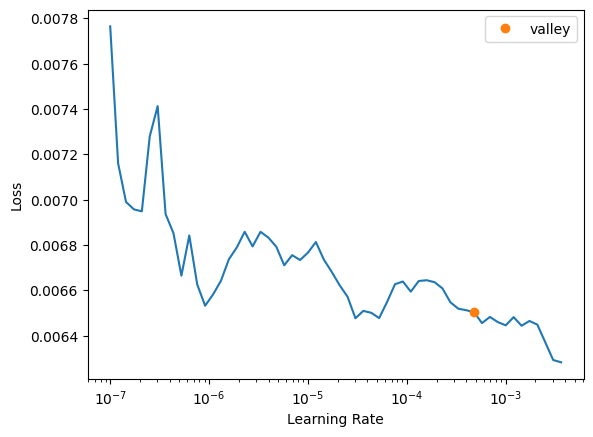

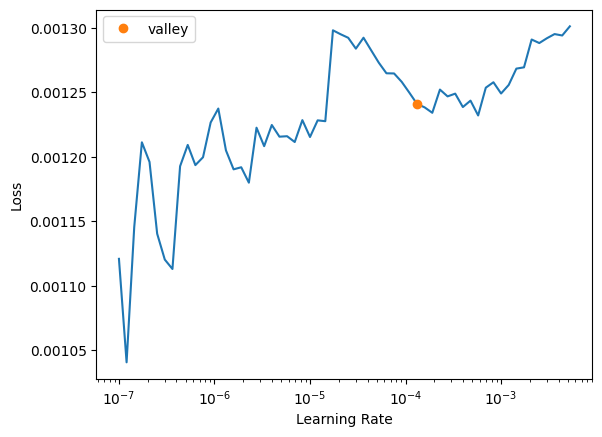

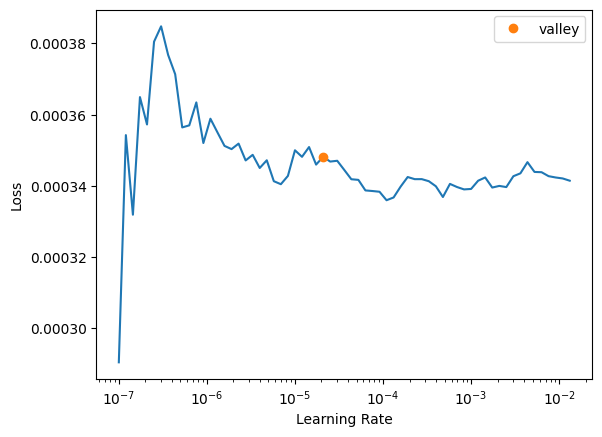

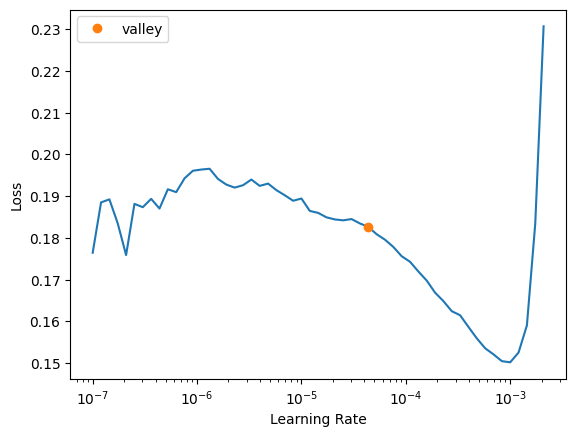

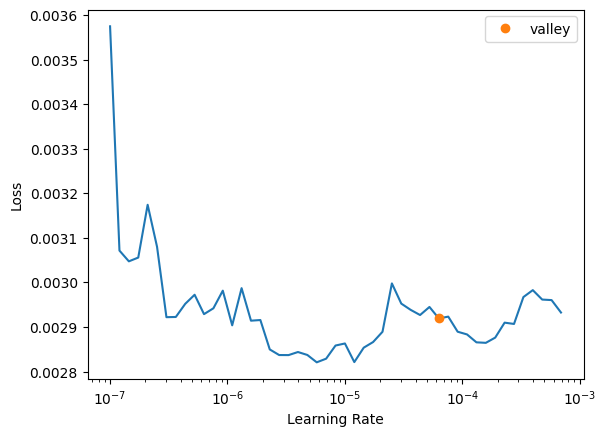

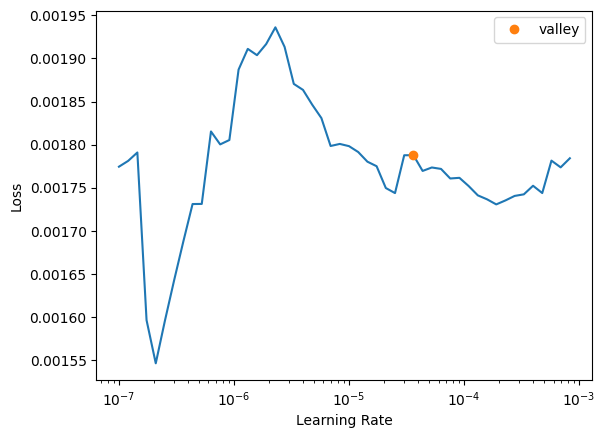

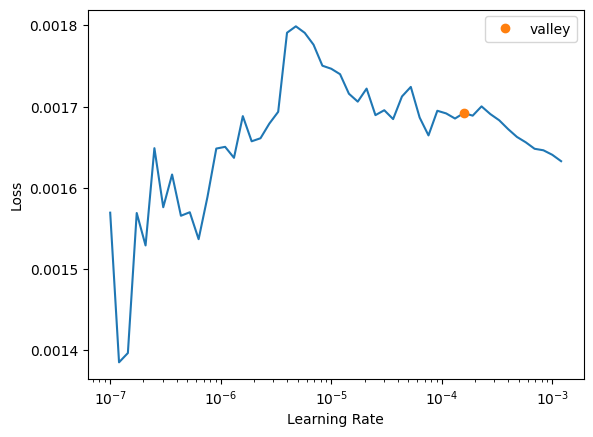

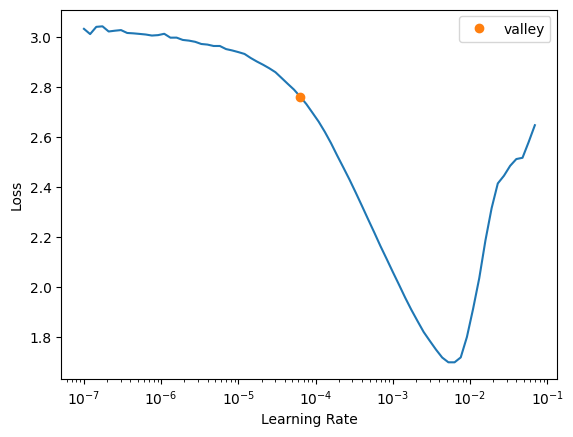

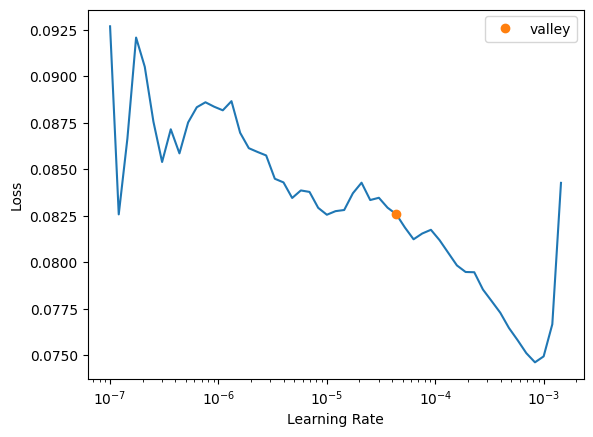

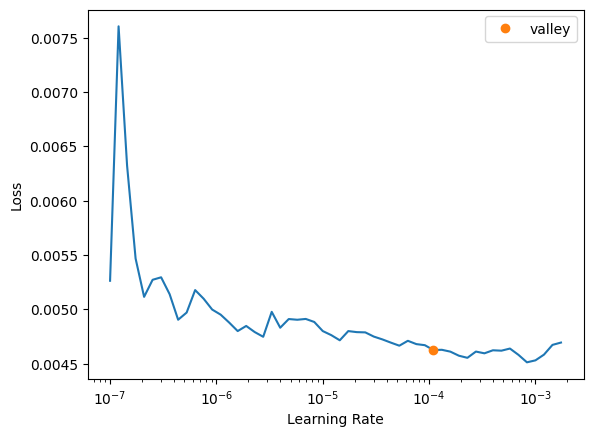

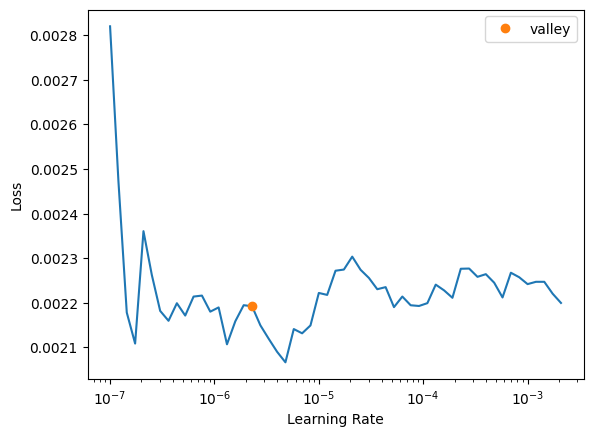

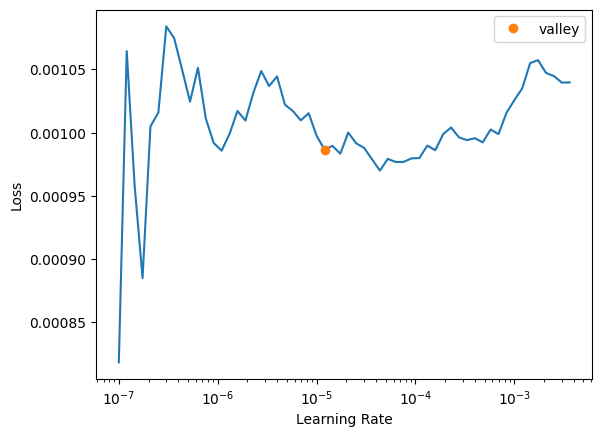

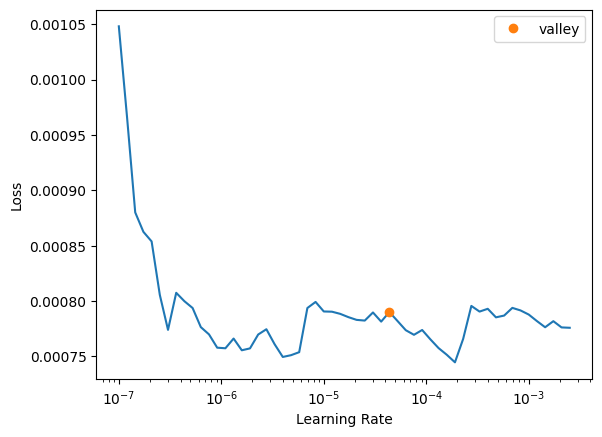

In [11]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for model in ['LeNet5', 'ResNet15']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][model] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]),  max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][model] = end-start
    
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(results['SHADE-ILS-GD'][model], f)

  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(time_mh['SHADE-ILS-GD'][model], f)



deque([1, 1, 0.2971769443246628], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.6963510513305664.
deque([1, 0.2971769443246628, 0.281590811023796], maxlen=3)
deque([0.2971769443246628, 0.281590811023796, 0.2683662607218049], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.3071177899837494.
deque([0.281590811023796, 0.2683662607218049, 0.7250445162560927], maxlen=3)
deque([0.2683662607218049, 0.7250445162560927, 0.8686630089154561], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.15696464478969574.
deque([0.7250445162560927, 0.8686630089154561, 0.8265453943154051], maxlen=3)
deque([0.8686630089154561, 0.8265453943154051, 0.7373202489034466], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.15112745761871338.
deque([0.8265453943154051, 0.7373202489034466, 0.3902788293497687], maxlen=3)
deque([0.7373202489034466, 0.3902788293497687, 0.35075266068029964], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.15164586901664734.
deque([0.3902788293497687, 0.35075266068029964, 0.5293837571175054], maxlen=3)
deque([0.35075266068029964, 0.5293837571175054, 0.4497574393813862], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.16558188199996948.
deque([0.5293837571175054, 0.4497574393813862, 0.37644658002439235], maxlen=3)
deque([0.4497574393813862, 0.37644658002439235, 0.14027596493347888], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.16903601586818695.
deque([0.37644658002439235, 0.14027596493347888, 0.0786857831317224], maxlen=3)
deque([0.14027596493347888, 0.0786857831317224, 0.2833875946383927], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.1673411726951599.
deque([0.0786857831317224, 0.2833875946383927, 0.001060833127077854], maxlen=3)
deque([0.2833875946383927, 0.001060833127077854, 0.02063165954049755], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.16841265559196472.
deque([0.001060833127077854, 0.02063165954049755, -0.008973695908889858], maxlen=3)
Reiniciado
deque([1, 1, 0.5430525881919843], maxlen=3)


Better model found at epoch 0 with valid_loss value: 3.4670872688293457.
deque([1, 0.5430525881919843, 0.3016212190249681], maxlen=3)


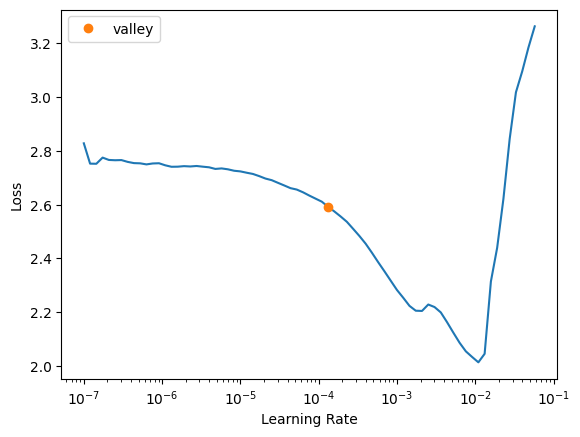

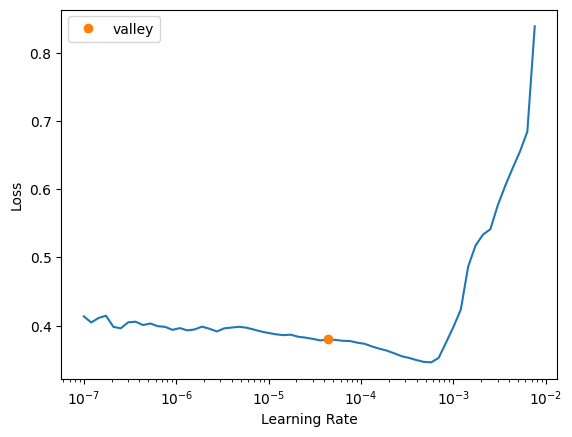

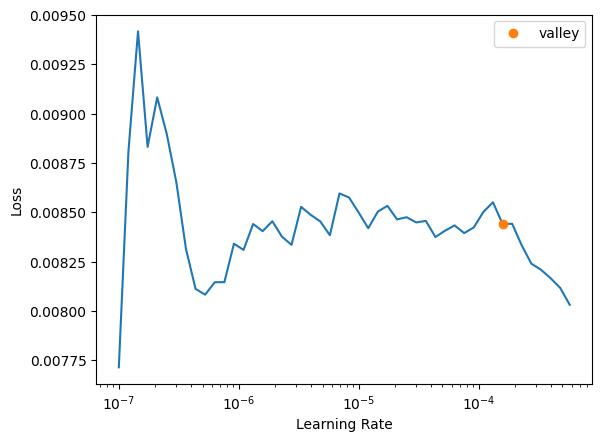

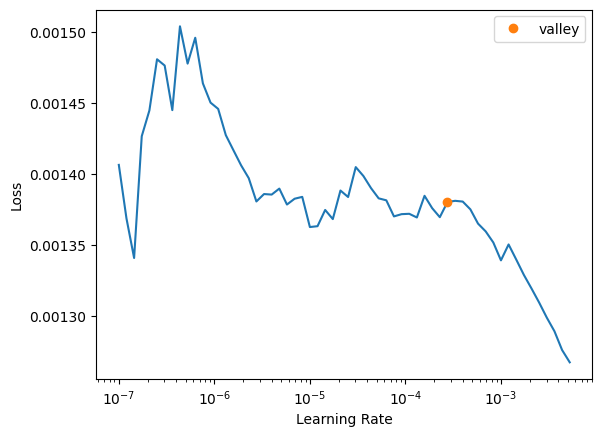

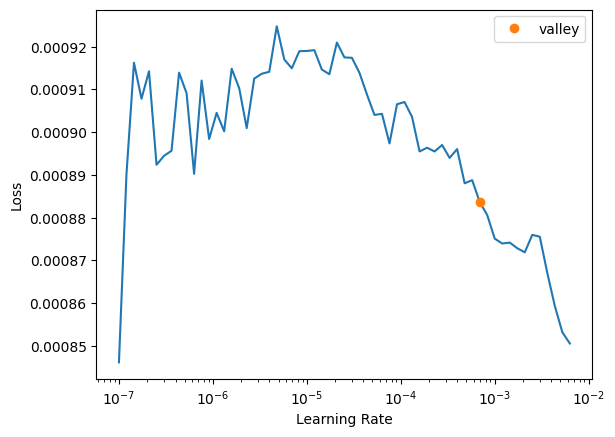

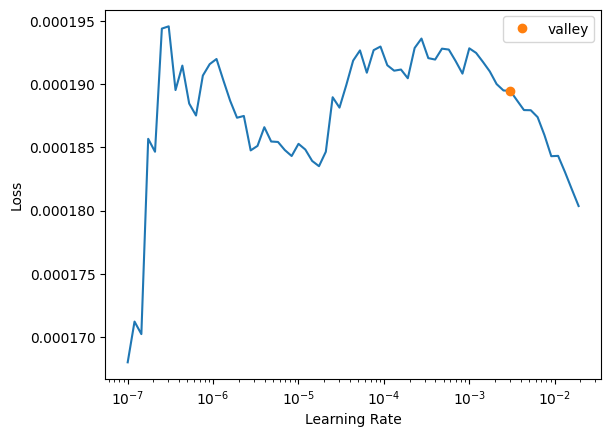

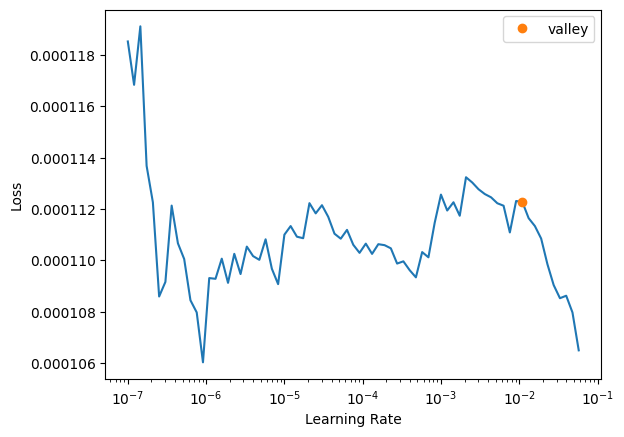

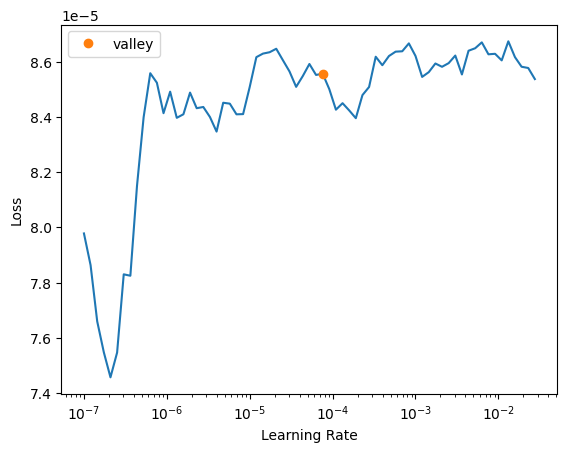

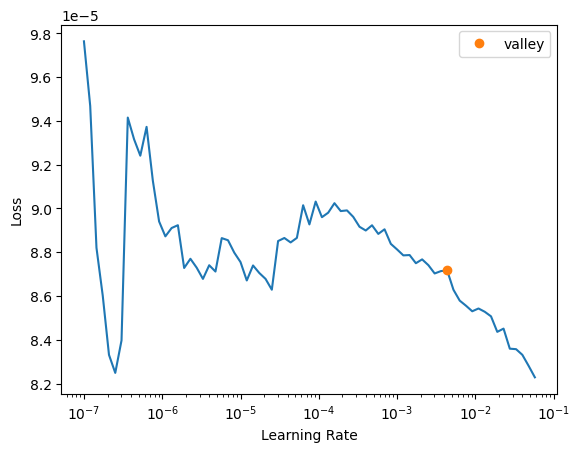

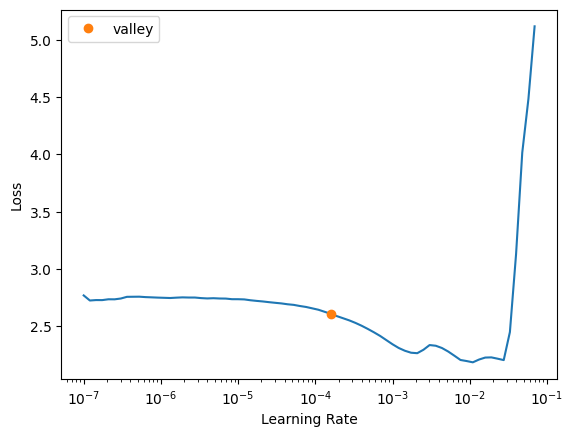

In [12]:
results['SHADE-ILS-GD'] = {}
for model in ['ResNet57']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][model] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]),  max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][model] = end-start
    
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(results['SHADE-ILS-GD'][model], f)

  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
      pickle.dump(time_mh['SHADE-ILS-GD'][model], f)

In [22]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for model in models:
  fitness_valid['SHADE-ILS-GD'][model] = []
  for ind in results['SHADE-ILS-GD'][model][3]:
    fitness_valid['SHADE-ILS-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [23]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS-GD for {model} model: {results['SHADE-ILS-GD'][model][2]}")
  print(f"Validation error of SHADE-ILS-GD for {model} model: {fitness_valid['SHADE-ILS-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][model]) - np.array(results['SHADE-ILS-GD'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][model])
  best['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for LeNet5 model: [2.5301520824432373, 0.015505312010645866, 0.002261660061776638, 0.0017675058916211128, 0.000637006713077426, 0.0006165773957036436, 0.0005968057666905224, 0.0005243220366537571, 0.0005243220366537571, 0.0005054806242696941, 0.00047079974319785833, 0.00047079974319785833, 0.00046992750139907, 0.00046992750139907, 0.00046992750139907, 0.00046992750139907, 0.00046992750139907, 0.00046992750139907, 0.0004096059419680387, 0.00031836668495088816, 0.00031728073372505605]
Validation error of SHADE-ILS-GD for LeNet5 model: [2.2991740703582764, 4.541190147399902, 5.833373069763184, 5.399249076843262, 5.047121047973633, 4.930699825286865, 5.386331081390381, 5.3153076171875, 5.3153076171875, 5.2376861572265625, 5.189630508422852, 5.189630508422852, 5.233177661895752, 5.233177661895752, 5.233177661895752, 5.233177661895752, 5.233177661895752, 5.233177661895752, 4.861199378967285, 4.736572265625, 4.711871147155762]
Difference: [-0.23097801  4.5256848

### Save or load

In [ ]:
#Save the mh results
file_path = f'saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
#Load the trained mh results
file_path = f'saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

### Comparison between MH

In [24]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for model in models:
  training['SHADE'][model] = results['SHADE'][model][6]
  training['SHADE-ILS'][model] = results['SHADE-ILS'][model][2]
  training['SHADE-GD'][model] = results['SHADE-GD'][model][2]
  training['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][2]

In [25]:
#Calculate accuracy and accuracy
acc = {}
for mh in algs:
  acc[mh] = {}
  for model in models:
    acc[mh][model] = []
    ind = 5 if mh == 'SHADE' else 3
    start = time.perf_counter()
    for ind in results[mh][model][ind]:
      utilsTFG.set_params_to_model(ind, mh_learners[model].model)
      mh_learners[model].model.eval()
      mh_learners[model].eval()
      preds, targs = mh_learners[model].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      acc[mh][model].append(accuracy(preds, targs))
    end = time.perf_counter()
    #time_full_mh[mh][model]+= end-start
    

<Figure size 1200x600 with 0 Axes>

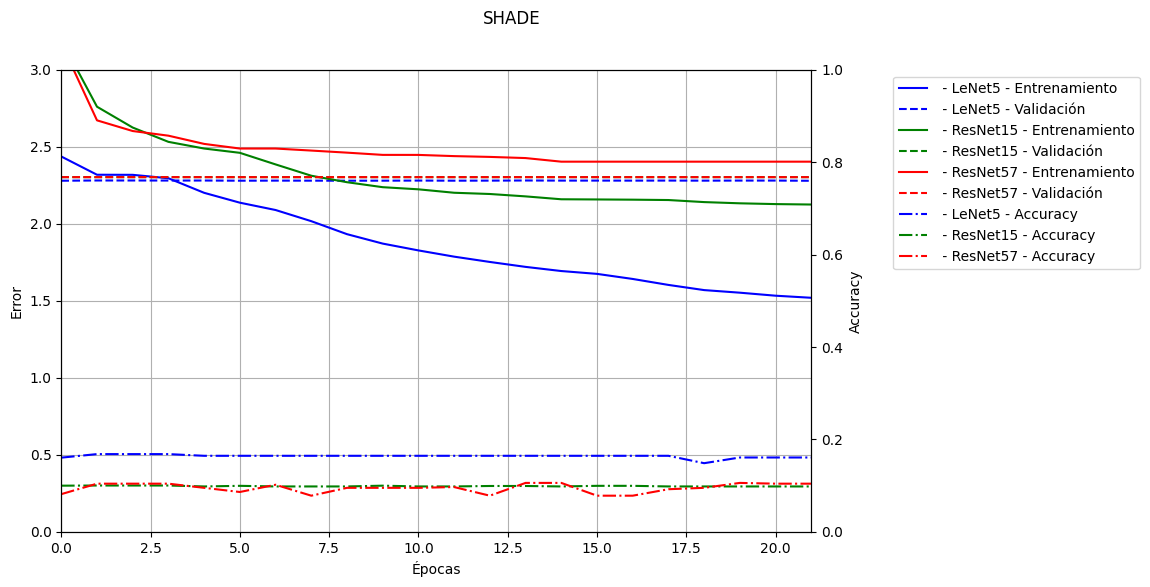

<Figure size 1200x600 with 0 Axes>

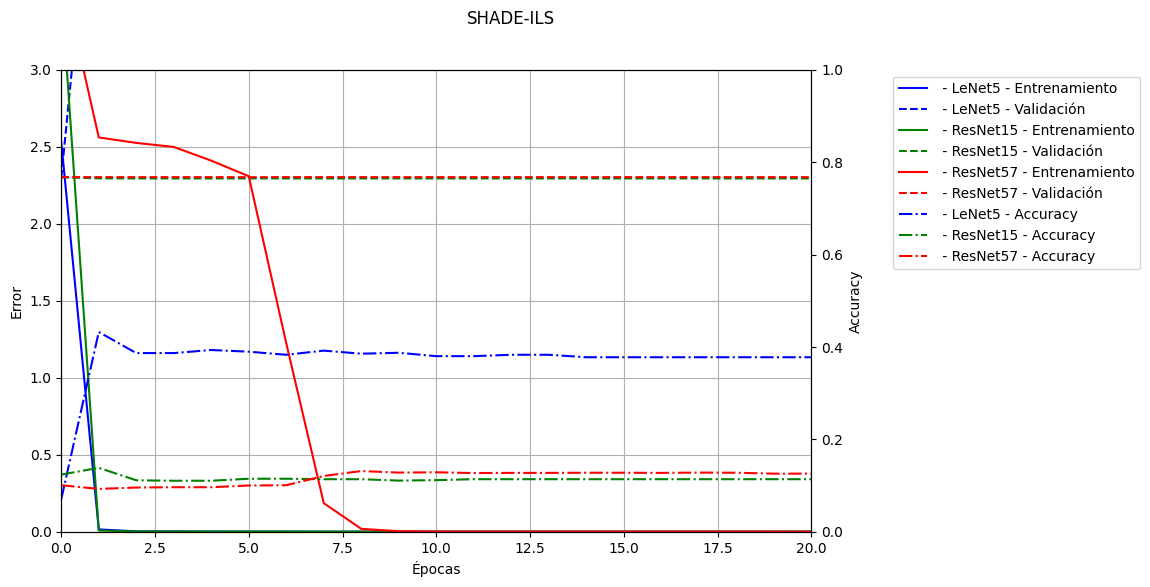

<Figure size 1200x600 with 0 Axes>

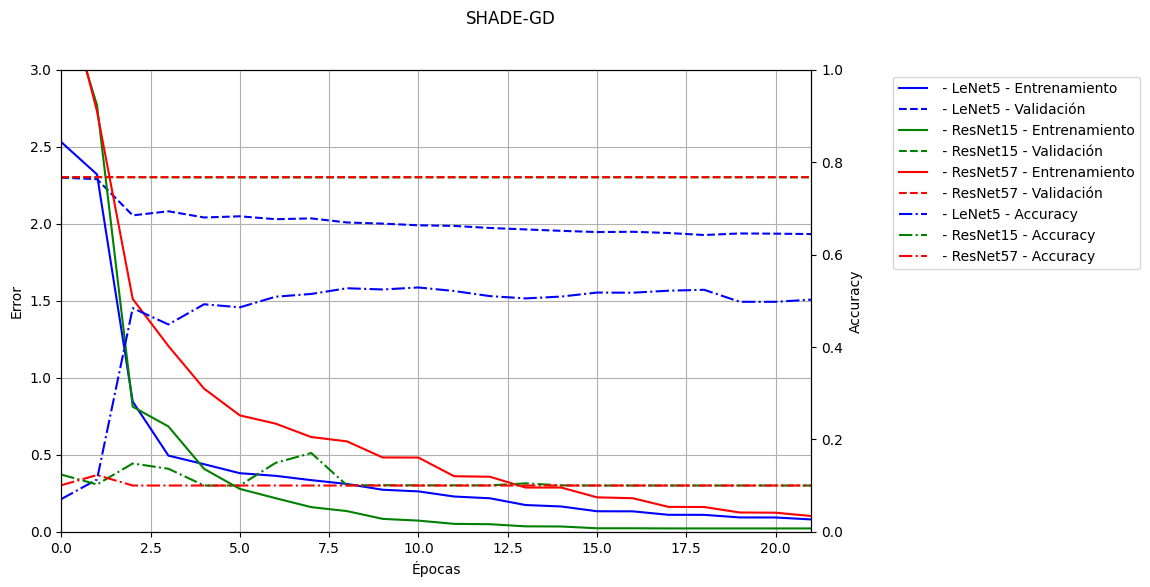

<Figure size 1200x600 with 0 Axes>

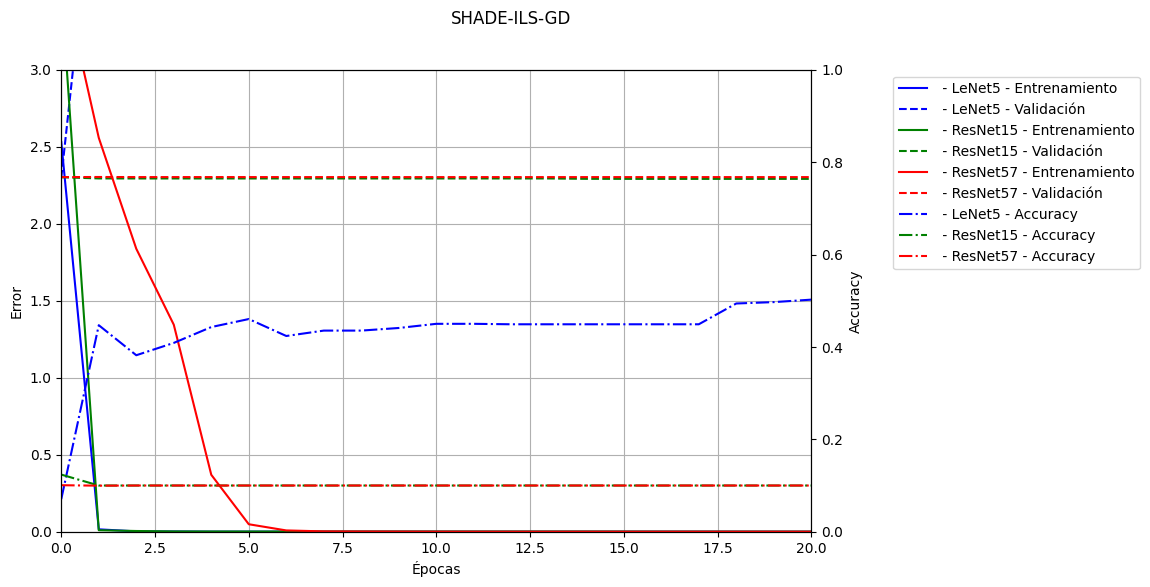

In [35]:
#Comparing the different layers version of the same MH
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], acc[alg], lim = 3, layers=models, names=models, title=f'{alg}', metric='accuracy')

<Figure size 1200x600 with 0 Axes>

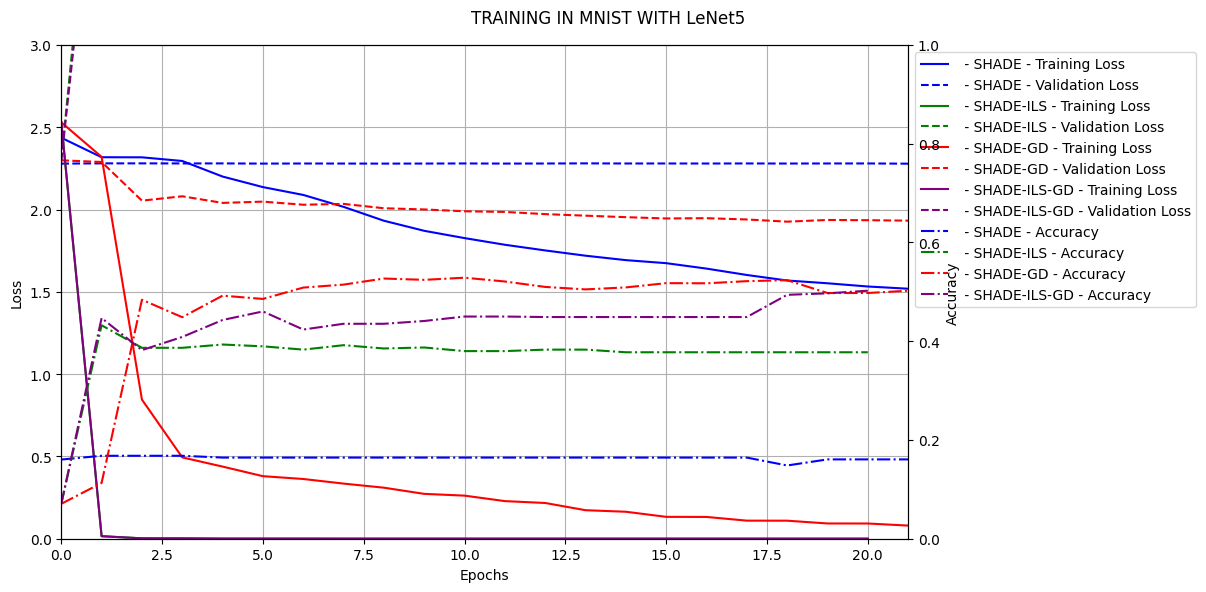

<Figure size 1200x600 with 0 Axes>

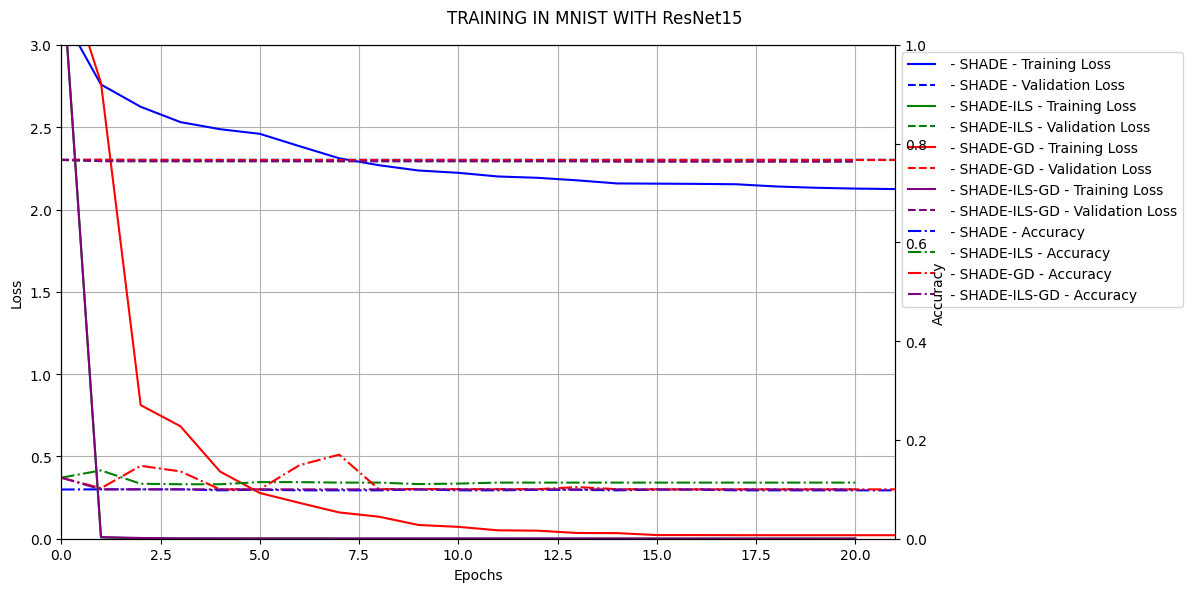

<Figure size 1200x600 with 0 Axes>

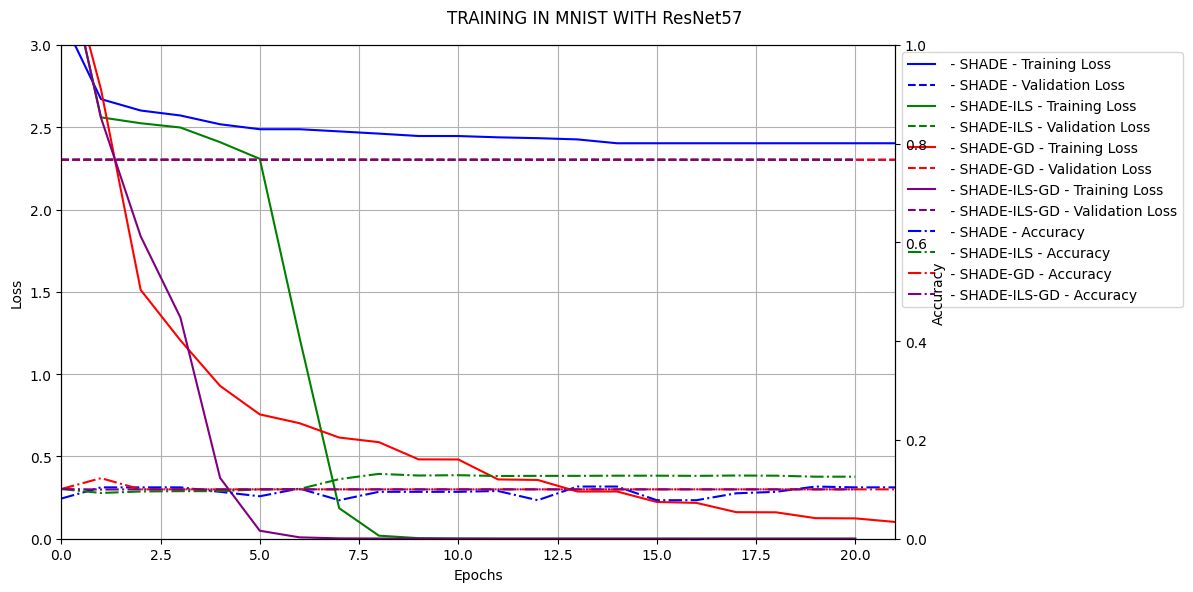

In [29]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
ac = {}
valid = {}
for model in models:
  train[model] = {}
  ac[model] = {}
  valid[model] = {}
  for alg in algs:
    train[model][alg] = training[alg][model]
    ac[model][alg] = acc[alg][model]
    valid[model][alg] = fitness_valid[alg][model]
  utilsTFG.plot_mh_mlp_training(train[model], valid[model], ac[model],  lim = 3, layers=names, names=names, title=f'TRAINING IN {plot_dataset} WITH {model}', metric='accuracy')

### Generalization

In [30]:
#Run the model in the test set
for mh in algs:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][model], mh_learners[model].model)
    mh_learners[model].model.eval()
    mh_learners[model].eval()
    preds, targs = mh_learners[model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate accuracy

    accur = utilsTFG.balanced_accuracy_func(preds, targs)


    loss = utilsTFG.err_param_w_model(mh_learners[model].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Model: {model}, Loss: {loss}, Accuracy: {accur}")

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE, Model: LeNet5, Loss: 2.2773454189300537, Accuracy: 0.17099999999999999


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE, Model: ResNet15, Loss: 2.302485227584839, Accuracy: 0.1004


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE, Model: ResNet57, Loss: 2.3025853633880615, Accuracy: 0.0824


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS, Model: LeNet5, Loss: 2.300225257873535, Accuracy: 0.0656


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS, Model: ResNet15, Loss: 2.2941839694976807, Accuracy: 0.1146


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS, Model: ResNet57, Loss: 2.302506685256958, Accuracy: 0.1


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-GD, Model: LeNet5, Loss: 1.924764633178711, Accuracy: 0.529


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-GD, Model: ResNet15, Loss: 2.301128387451172, Accuracy: 0.1


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-GD, Model: ResNet57, Loss: 2.3025619983673096, Accuracy: 0.1202


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS-GD, Model: LeNet5, Loss: 2.300225257873535, Accuracy: 0.0656


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS-GD, Model: ResNet15, Loss: 2.292073965072632, Accuracy: 0.1


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS-GD, Model: ResNet57, Loss: 2.302645444869995, Accuracy: 0.1


## Time comparison

In [31]:
#Compare times for each algorithm and layer

#GD
for alg, time_model in time_mh.items():
  for model, time in time_model.items():
    print(f'Time consumed by {alg} training with {model}: {time:.04f} seconds')

#MH
for optims, time_model in time_gd.items():
  for model, time in time_model.items():
    print(f'Time consumed by {optims} training with {model}: {time:.04f} seconds')



Time consumed by SHADE training with LeNet5: 6852.8573 seconds
Time consumed by SHADE training with ResNet15: 7639.8372 seconds
Time consumed by SHADE training with ResNet57: 8032.2240 seconds
Time consumed by SHADE-ILS training with LeNet5: 7190.3812 seconds
Time consumed by SHADE-ILS training with ResNet15: 7927.3080 seconds
Time consumed by SHADE-ILS training with ResNet57: 8716.4520 seconds
Time consumed by SHADE-GD training with LeNet5: 6814.9777 seconds
Time consumed by SHADE-GD training with ResNet15: 7412.8938 seconds
Time consumed by SHADE-GD training with ResNet57: 8559.9495 seconds
Time consumed by SHADE-ILS-GD training with LeNet5: 6661.4245 seconds
Time consumed by SHADE-ILS-GD training with ResNet15: 7526.6524 seconds
Time consumed by SHADE-ILS-GD training with ResNet57: 9467.4955 seconds
Time consumed by NAG training with LeNet5: 52.5829 seconds
Time consumed by NAG training with ResNet15: 60.0313 seconds
Time consumed by NAG training with ResNet57: 72.2850 seconds
Time 

In [15]:
for alg, time_layers in time_full_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.03f} seconds')

Time consumed by SHADE training with LeNet5 layers: 7048.023 seconds
Time consumed by SHADE training with ResNet15 layers: 7835.929 seconds
Time consumed by SHADE training with ResNet57 layers: 8234.853 seconds
Time consumed by SHADE-ILS training with LeNet5 layers: 7254.432 seconds
Time consumed by SHADE-ILS training with ResNet15 layers: 7991.074 seconds
Time consumed by SHADE-ILS training with ResNet57 layers: 8785.166 seconds
